# Hello PixelCNN

In [1]:
# Prerequisites
import sys
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from utils import display

print("Python Version: ", sys.version)

2025-06-10 13:23:42.584767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749587022.701049    4694 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749587022.732731    4694 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749587022.984467    4694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749587022.984489    4694 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749587022.984491    4694 computation_placer.cc:177] computation placer alr

Python Version:  3.12.3 (main, Feb  4 2025, 14:48:35) [GCC 13.3.0]


### Get Data
Use FashionMNIST from TensorFlow datasets

In [2]:

(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

### Preprocess Data

Scale down in size and image depth to make the training time reasonable

I0000 00:00:1749587070.046936    4694 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9329 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:04:00.0, compute capability: 7.0


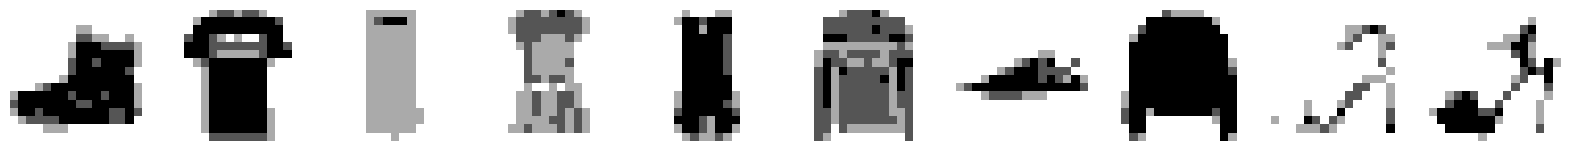

In [3]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4

# Function to preprocess the images
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


# Preprocess the training data
input_data, output_data = preprocess(x_train)

# Display some sample preprocessed images
display(input_data)

### Define PixelCNN

#### Define Masked Convolutional Layers

In [4]:
# Type A: value of the central pixel is masked
# Type B: value of the central pixel is not masked
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)    # Based on regular Conv2D layer

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.shape
        self.mask = np.zeros(shape=kernel_shape)   # Intialize mask with zeros
        self.mask[: kernel_shape[0] // 2, ...] = 1.0  # preceding rows set to 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B": # Type B: central pixel is not masked
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)  # Multiply the mask with filter weights
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

#### Define Residual Blocks 

In [5]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

#### Define PixelCNN itself

In [6]:
N_FILTERS = 128    # Number of filters in the convolutional layers
RESIDUAL_BLOCKS = 5   # Number of residual blocks in the network

# Define the PixelCNN model
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d (MaskedConv2D)    │ (None, 16, 16, 128)    │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 16, 16, 128)    │        53,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 16, 16, 128)    │        53,504 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_6 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masked_conv2d_7 (MaskedConv2D)  │ (None, 16, 16, 128)    │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 4)      │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 307,460 (1.17 MB)

 Trainable params: 307,460 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

### Train the PixelCNN

In [7]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [8]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150


I0000 00:00:1749587095.031597    4915 service.cc:152] XLA service 0x74b9b000b2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749587095.031618    4915 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2025-06-10 13:24:55.137535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-10 13:24:55.406355: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1749587095.741094    4915 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-10 13:24:56.320823: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.74 = (f32[128,64,16,16]{3,2,1,0},

  9/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.3592

I0000 00:00:1749587098.265172    4915 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


464/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6406

2025-06-10 13:25:04.478793: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-10 13:25:04.905657: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.74 = (f32[96,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[96,64,16,16]{3,2,1,0} %bitcast.7551, f32[64,64,3,3]{3,2,1,0} %bitcast.7542, f32[64]{0} %bitcast.7611), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/residual_block_1/masked_conv2d_1_1/conv2d_2_1/convolution" source_file="/home/jari/MyGitHub/ML_Generative_AI_Experiments/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_oper

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6390

2025-06-10 13:25:07.019209: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.59 = (f32[10,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,64,16,16]{3,2,1,0} %bitcast.793, f32[64,64,3,3]{3,2,1,0} %bitcast.1105, f32[64]{0} %bitcast.806), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/residual_block_1/masked_conv2d_1_1/conv2d_2_1/convolution" source_file="/home/jari/MyGitHub/ML_Generative_AI_Experiments/.venv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}



Saved to ./output/generated_img_000.png


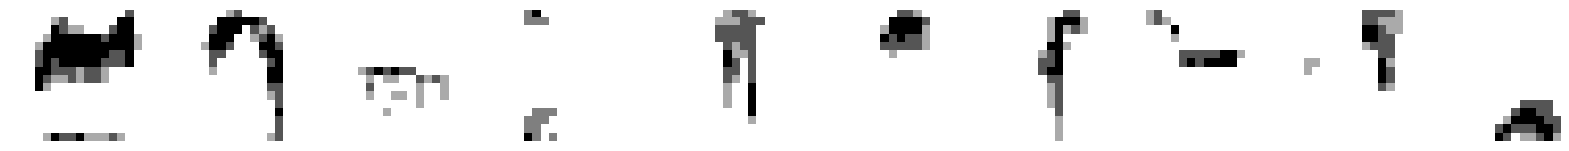

469/469 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - loss: 0.6387
Epoch 2/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4037
Saved to ./output/generated_img_001.png


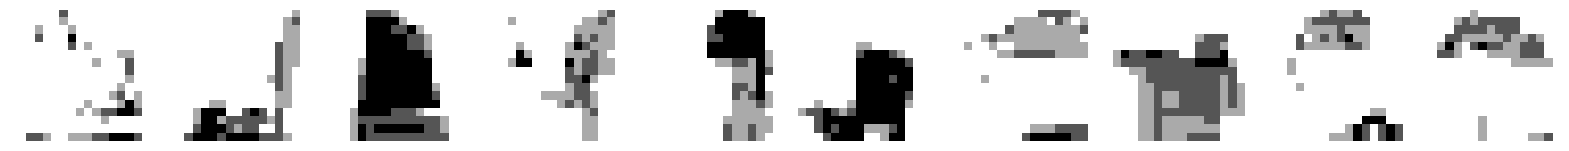

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.4037
Epoch 3/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3879
Saved to ./output/generated_img_002.png


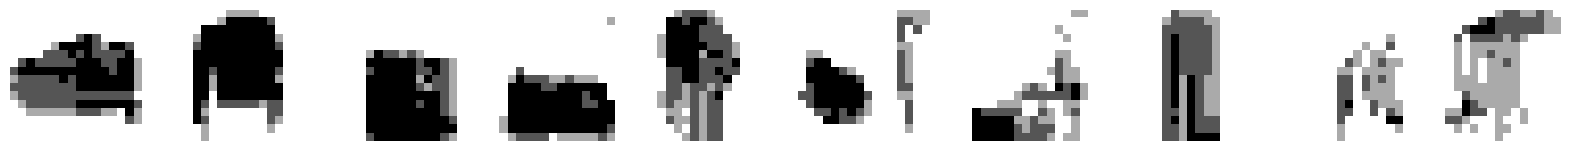

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3879
Epoch 4/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3825
Saved to ./output/generated_img_003.png


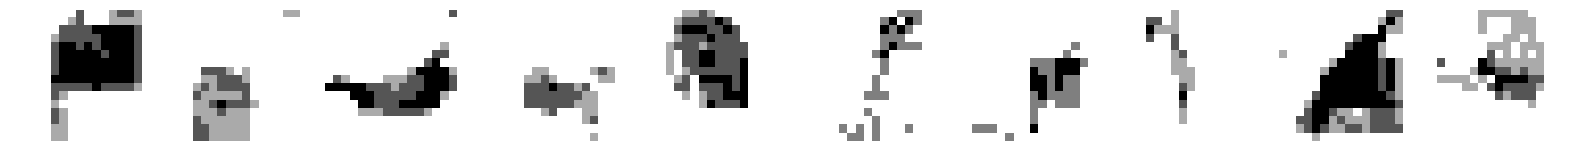

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3825
Epoch 5/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3770
Saved to ./output/generated_img_004.png


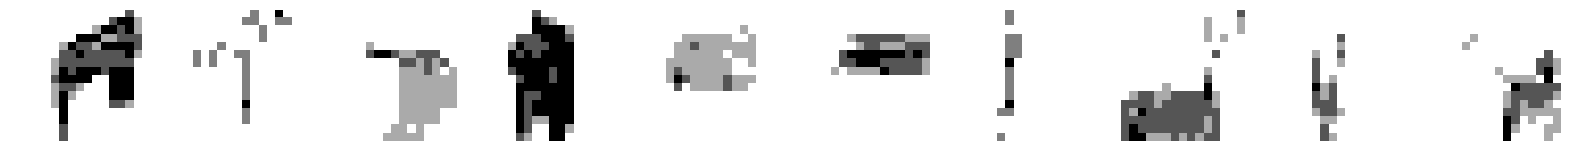

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3770
Epoch 6/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3737
Saved to ./output/generated_img_005.png


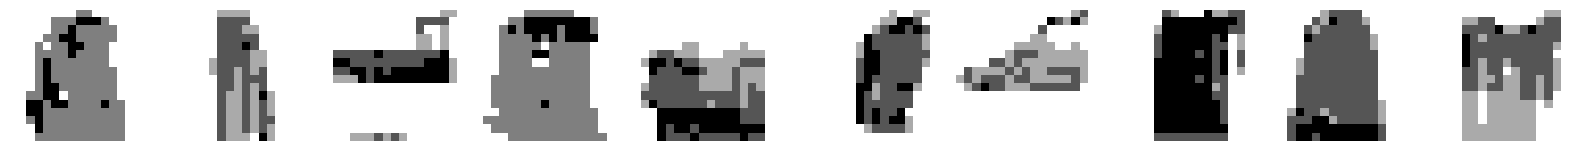

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3737
Epoch 7/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3715
Saved to ./output/generated_img_006.png


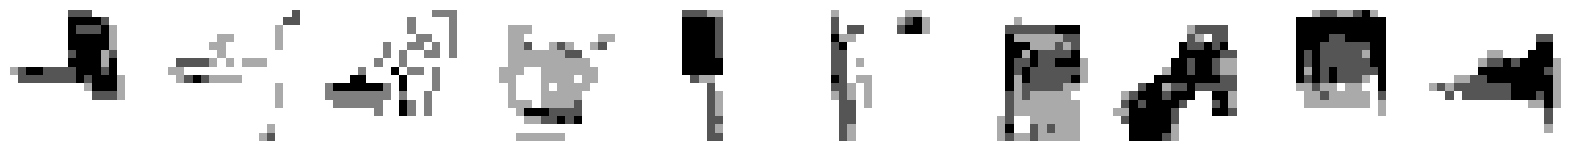

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3715
Epoch 8/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3683
Saved to ./output/generated_img_007.png


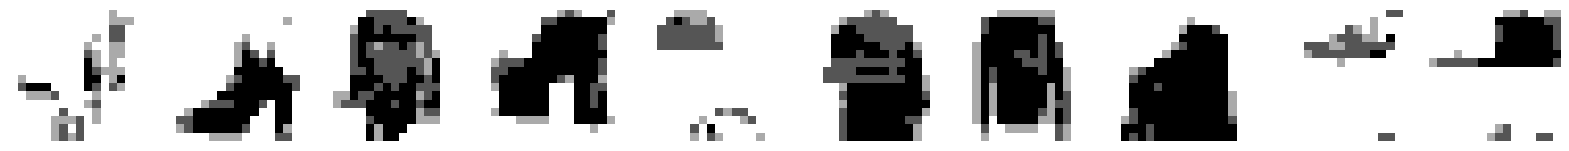

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3683
Epoch 9/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3643
Saved to ./output/generated_img_008.png


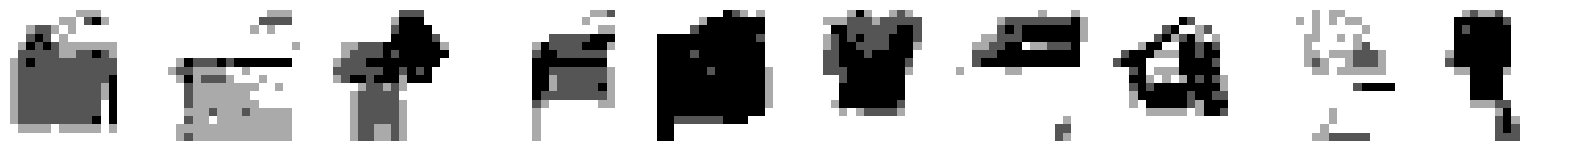

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3643
Epoch 10/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3635
Saved to ./output/generated_img_009.png


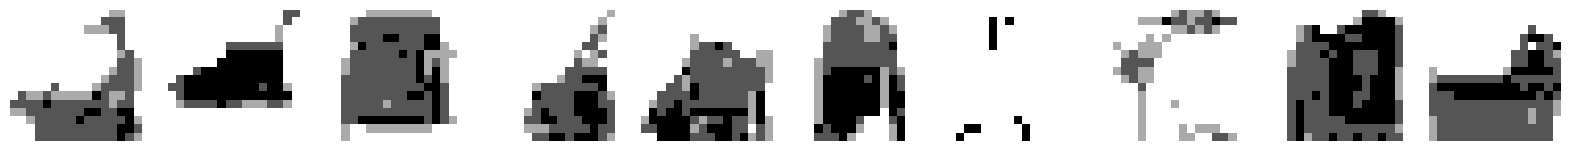

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3635
Epoch 11/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3609
Saved to ./output/generated_img_010.png


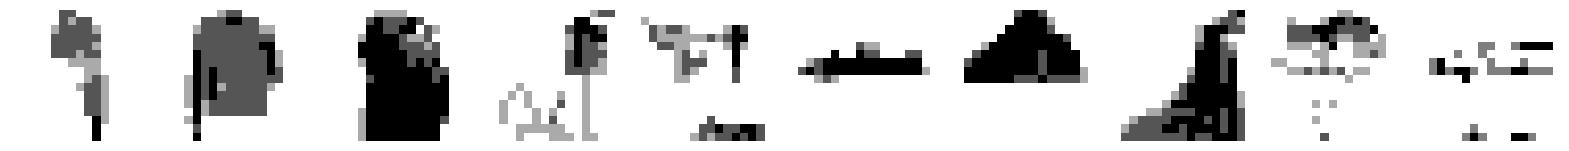

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3609
Epoch 12/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3594
Saved to ./output/generated_img_011.png


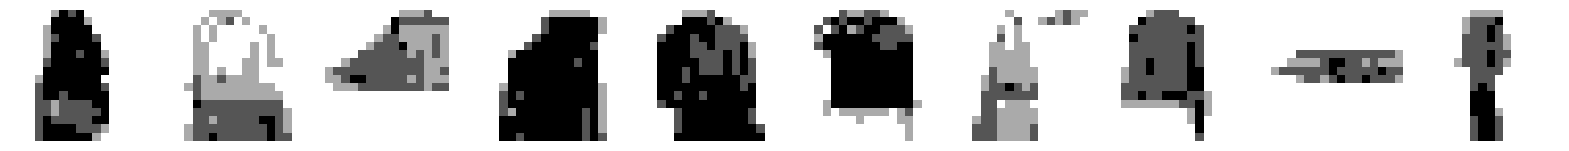

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3594
Epoch 13/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3583
Saved to ./output/generated_img_012.png


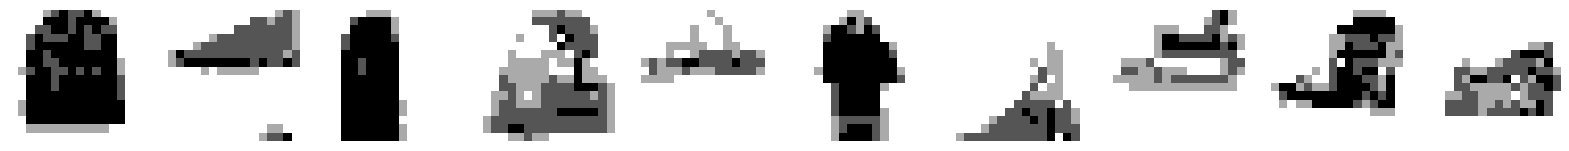

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3583
Epoch 14/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3556
Saved to ./output/generated_img_013.png


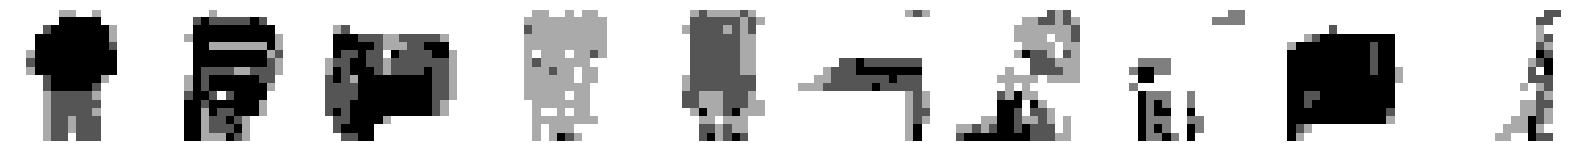

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3556
Epoch 15/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3541
Saved to ./output/generated_img_014.png


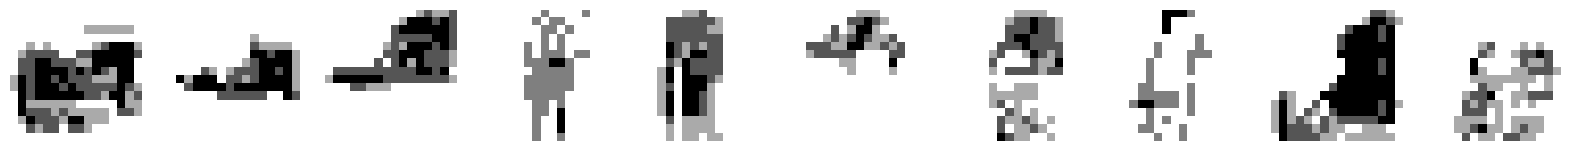

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3541
Epoch 16/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3531
Saved to ./output/generated_img_015.png


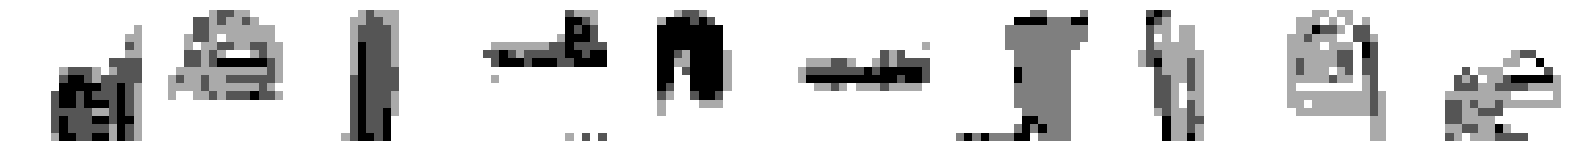

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3531
Epoch 17/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3532
Saved to ./output/generated_img_016.png


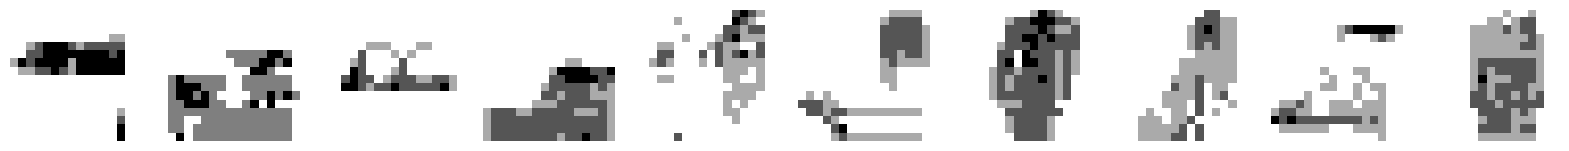

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3532
Epoch 18/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3521
Saved to ./output/generated_img_017.png


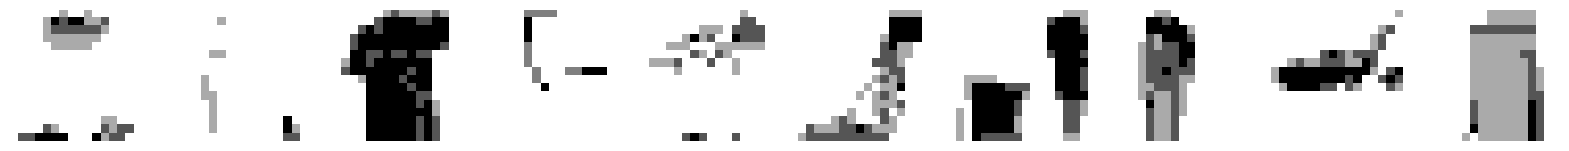

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3521
Epoch 19/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3504
Saved to ./output/generated_img_018.png


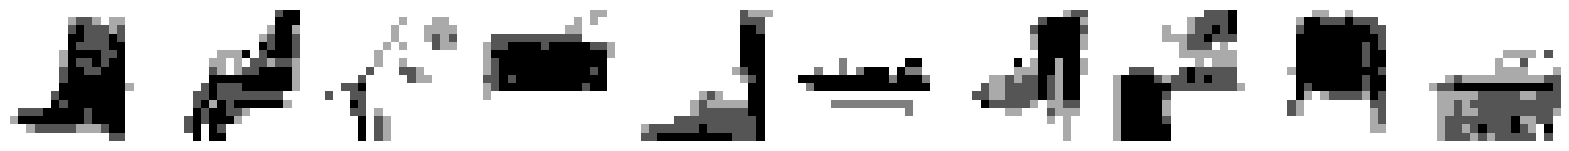

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3504
Epoch 20/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3500
Saved to ./output/generated_img_019.png


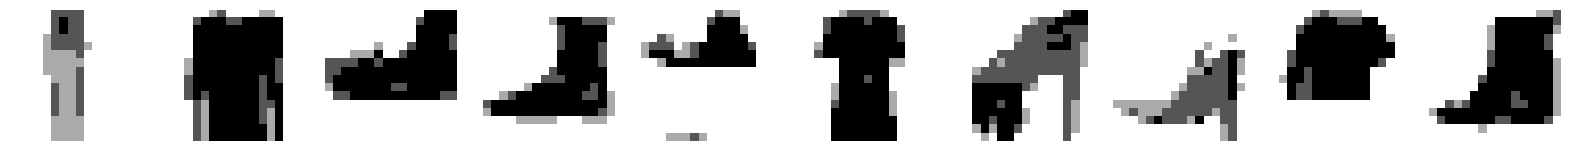

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3500
Epoch 21/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3495
Saved to ./output/generated_img_020.png


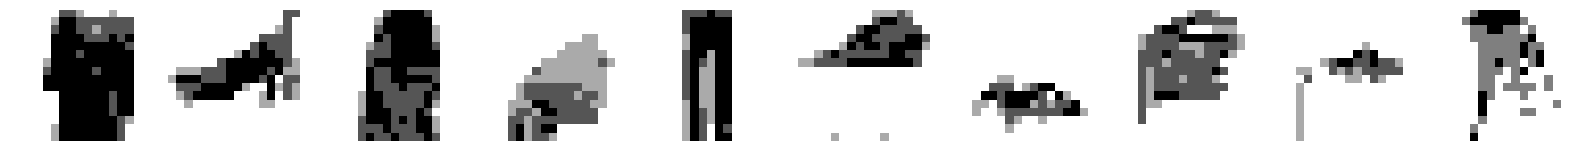

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3495
Epoch 22/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3477
Saved to ./output/generated_img_021.png


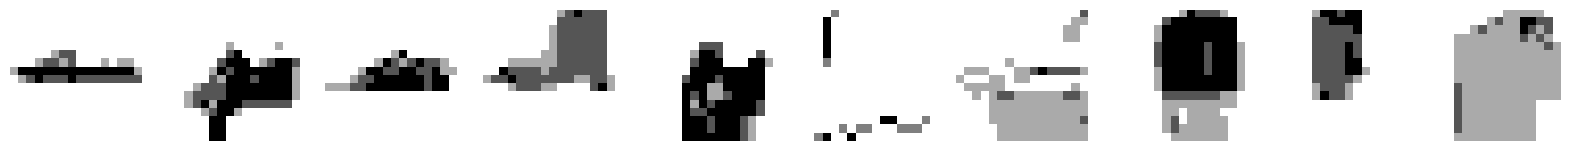

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3477
Epoch 23/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3467
Saved to ./output/generated_img_022.png


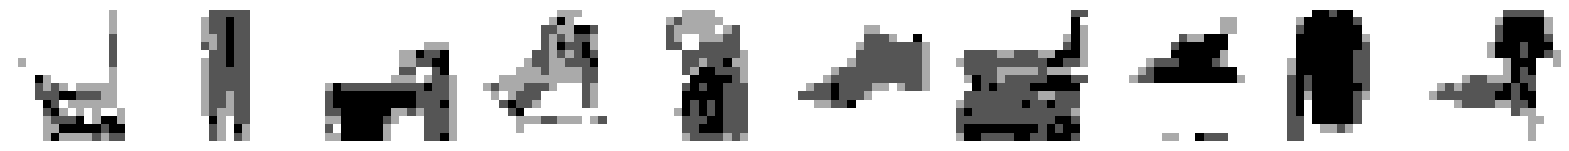

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3467
Epoch 24/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3467
Saved to ./output/generated_img_023.png


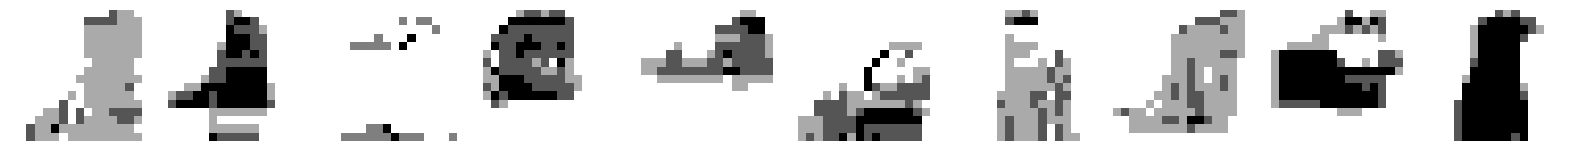

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3467
Epoch 25/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3459
Saved to ./output/generated_img_024.png


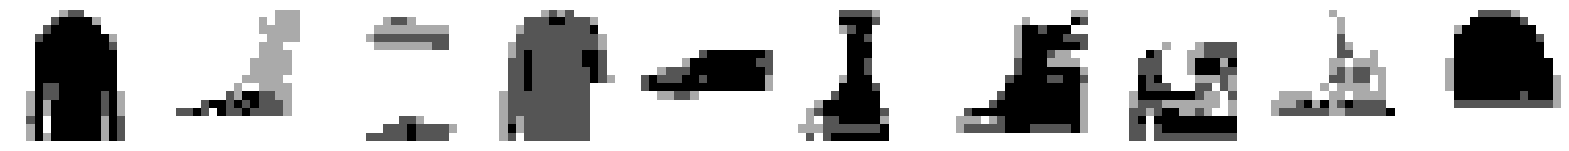

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3459
Epoch 26/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3465
Saved to ./output/generated_img_025.png


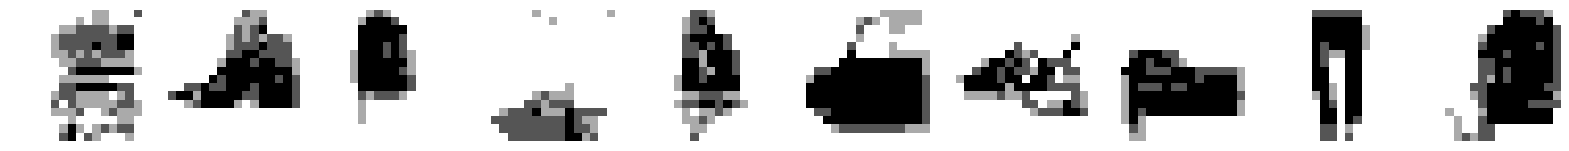

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3465
Epoch 27/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3445
Saved to ./output/generated_img_026.png


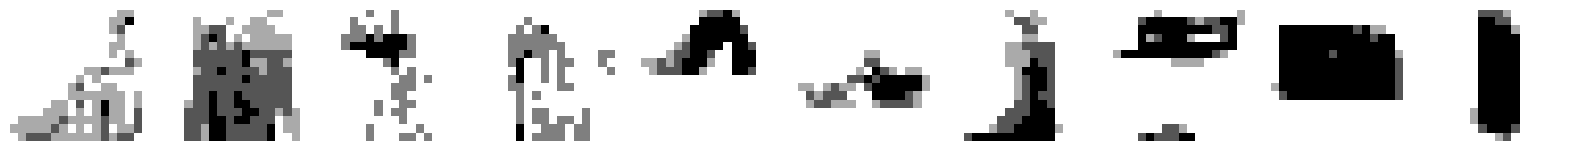

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3445
Epoch 28/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3443
Saved to ./output/generated_img_027.png


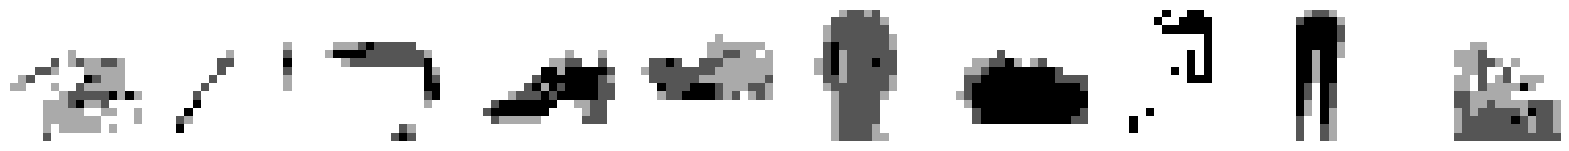

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3443
Epoch 29/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3442
Saved to ./output/generated_img_028.png


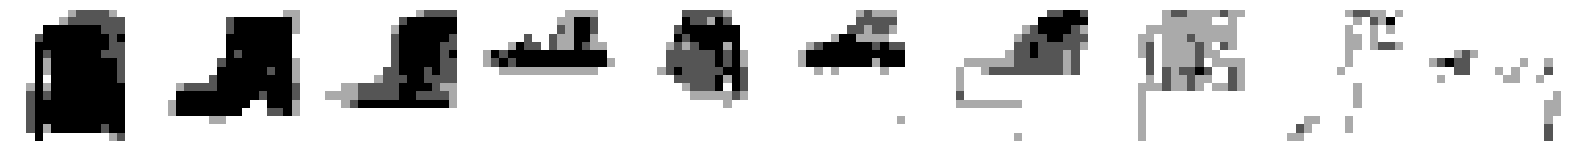

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3442
Epoch 30/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3433
Saved to ./output/generated_img_029.png


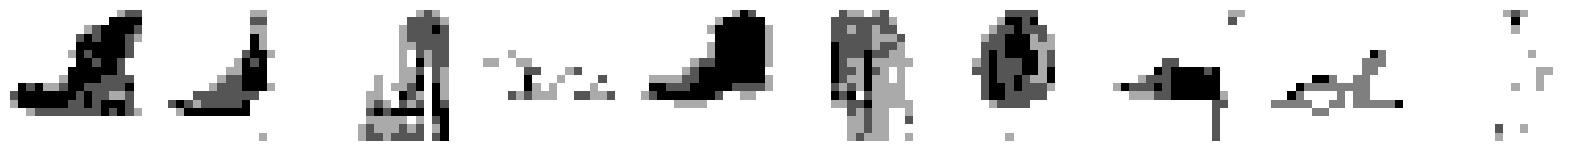

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3433
Epoch 31/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3435
Saved to ./output/generated_img_030.png


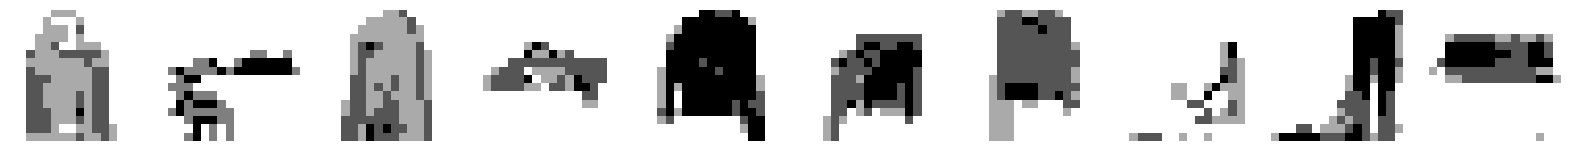

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3435
Epoch 32/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3428
Saved to ./output/generated_img_031.png


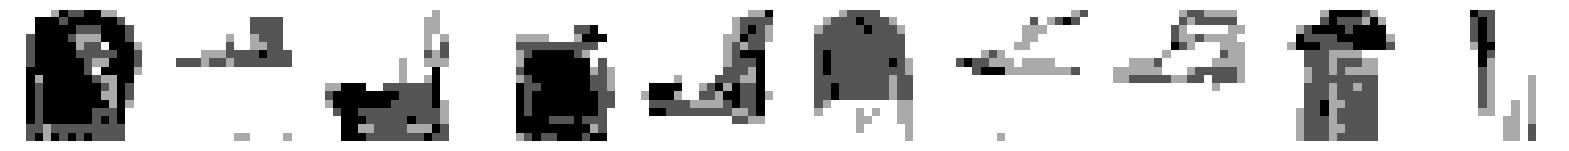

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3428
Epoch 33/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3421
Saved to ./output/generated_img_032.png


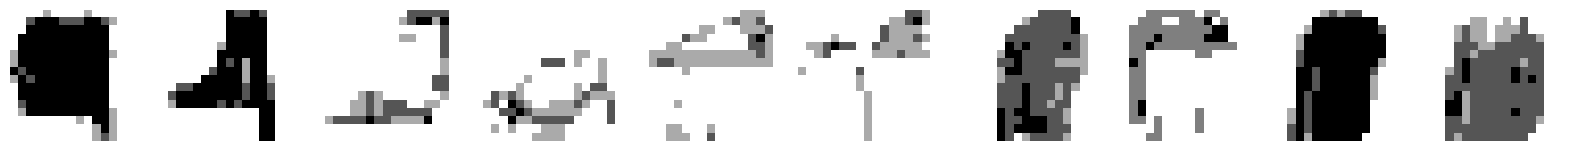

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3421
Epoch 34/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3408
Saved to ./output/generated_img_033.png


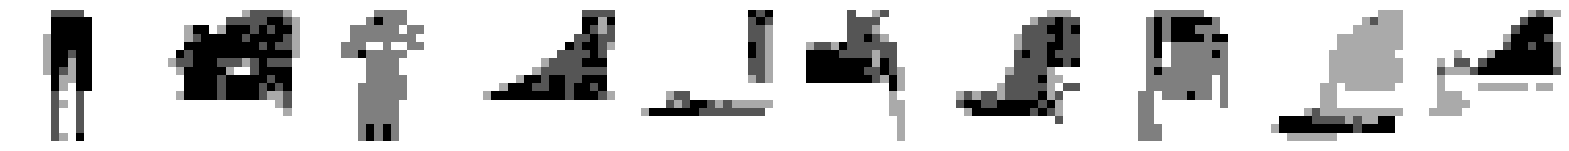

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.3408
Epoch 35/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3415
Saved to ./output/generated_img_034.png


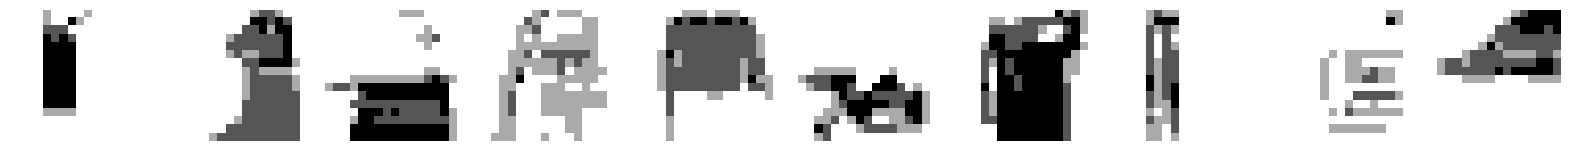

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.3415
Epoch 36/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3394
Saved to ./output/generated_img_035.png


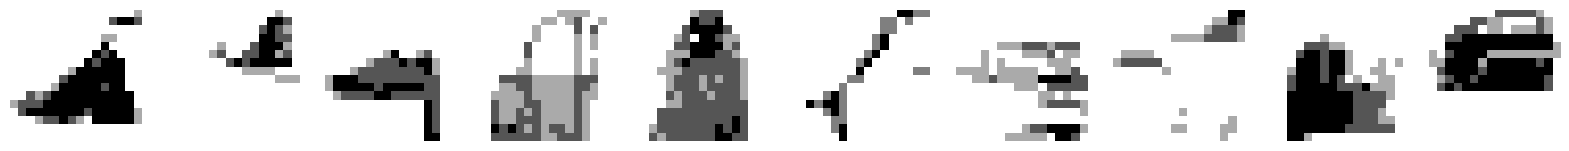

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3394
Epoch 37/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3392
Saved to ./output/generated_img_036.png


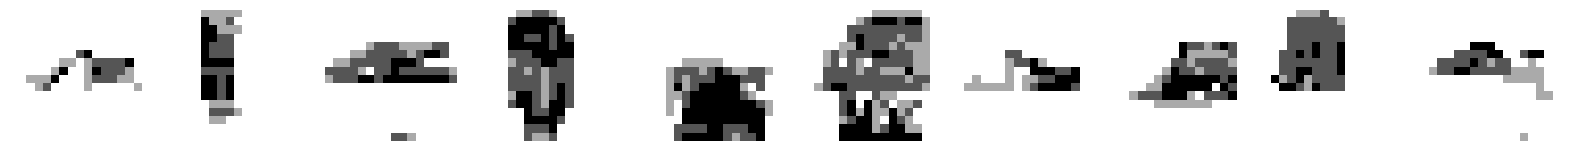

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3392
Epoch 38/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3399
Saved to ./output/generated_img_037.png


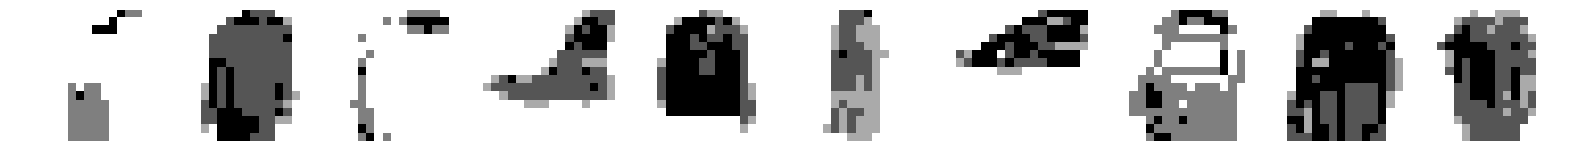

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3399
Epoch 39/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3398
Saved to ./output/generated_img_038.png


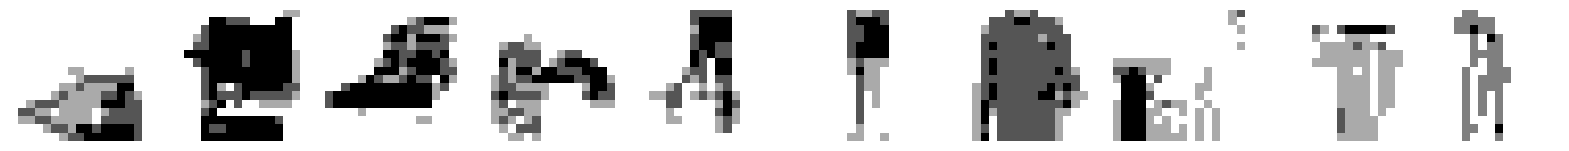

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3398
Epoch 40/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3388
Saved to ./output/generated_img_039.png


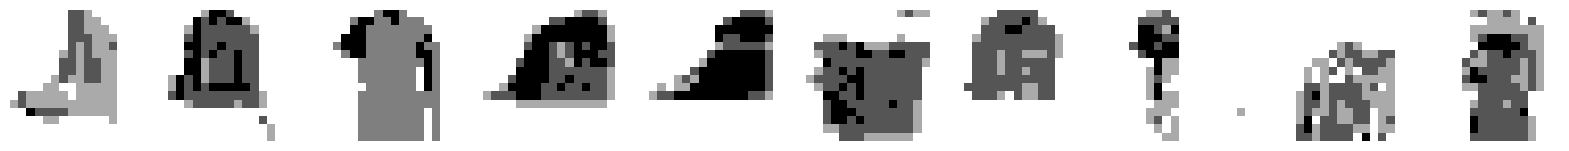

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3388
Epoch 41/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3397
Saved to ./output/generated_img_040.png


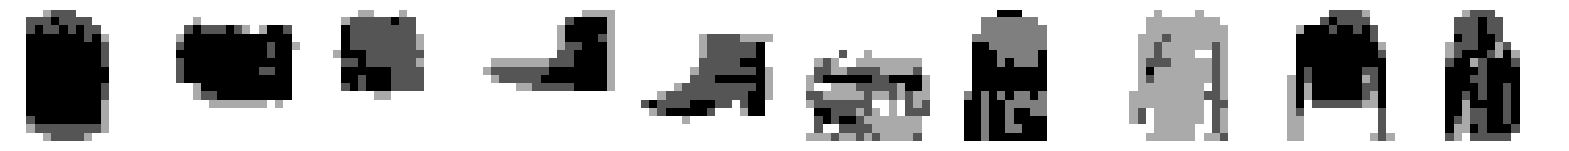

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3397
Epoch 42/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3376
Saved to ./output/generated_img_041.png


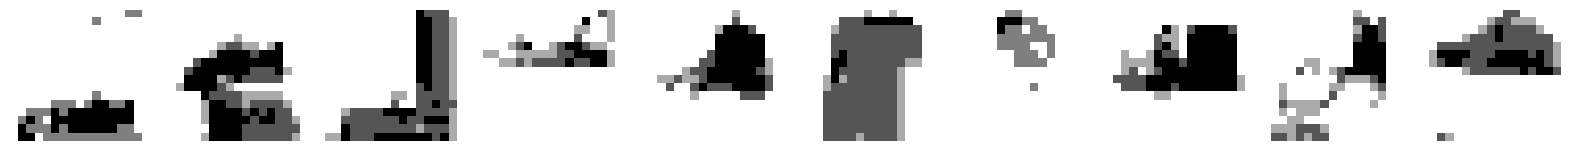

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3376
Epoch 43/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3393
Saved to ./output/generated_img_042.png


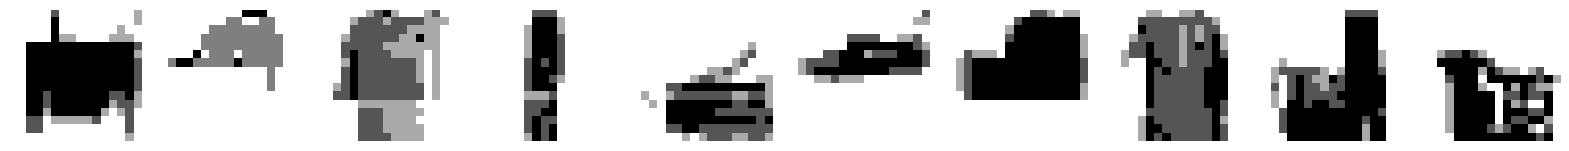

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3393
Epoch 44/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3385
Saved to ./output/generated_img_043.png


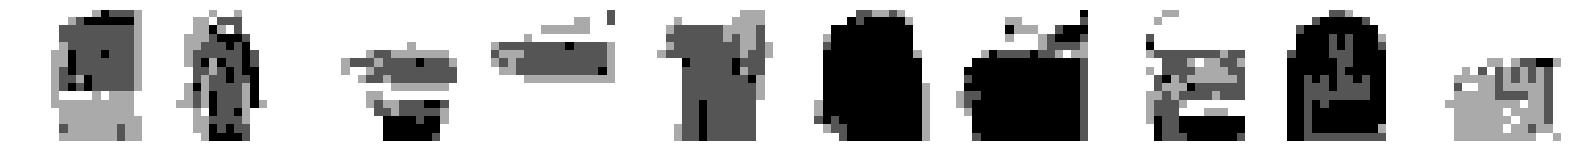

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3385
Epoch 45/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3371
Saved to ./output/generated_img_044.png


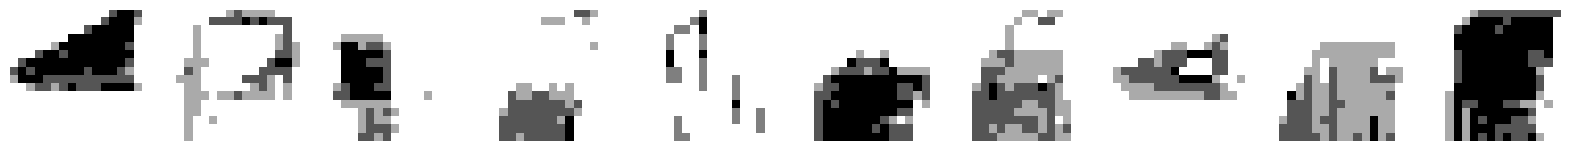

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.3371
Epoch 46/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3366
Saved to ./output/generated_img_045.png


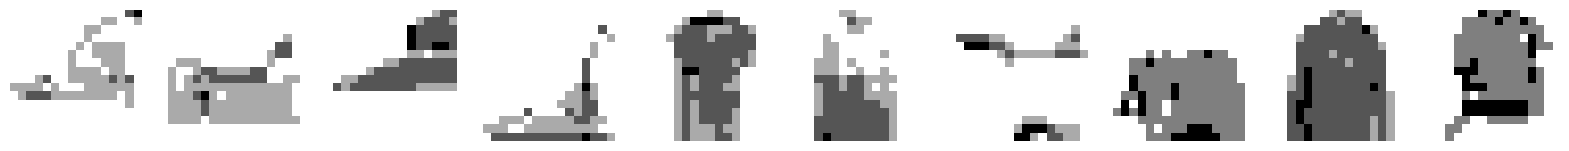

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3366
Epoch 47/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3376
Saved to ./output/generated_img_046.png


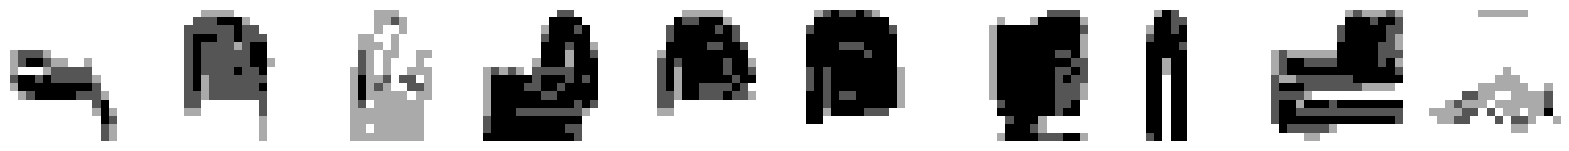

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3376
Epoch 48/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3366
Saved to ./output/generated_img_047.png


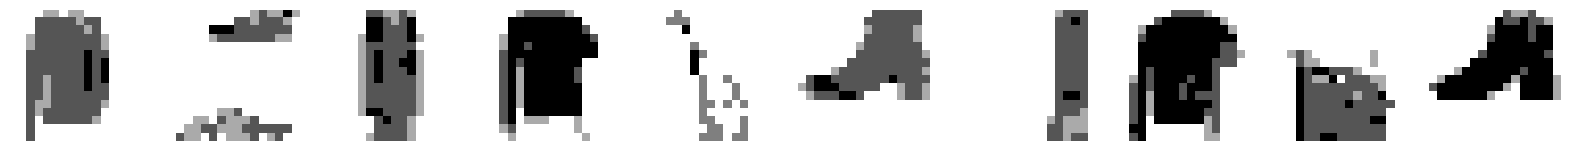

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3366
Epoch 49/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3363
Saved to ./output/generated_img_048.png


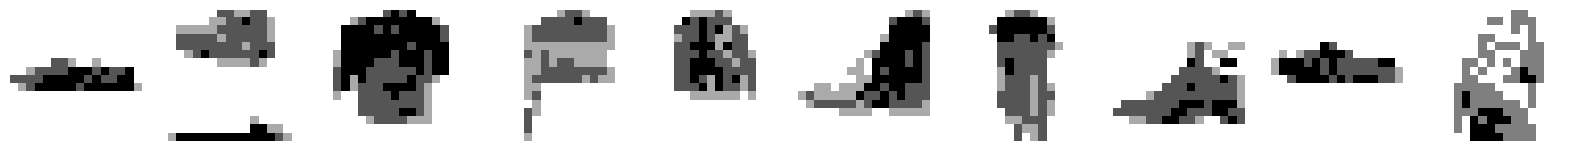

469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.3363
Epoch 50/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3366
Saved to ./output/generated_img_049.png


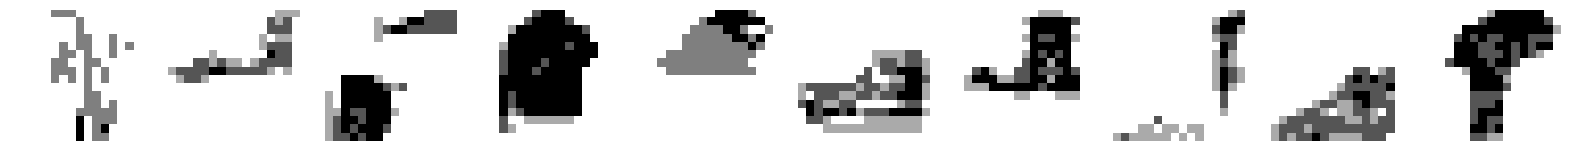

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3366
Epoch 51/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3356
Saved to ./output/generated_img_050.png


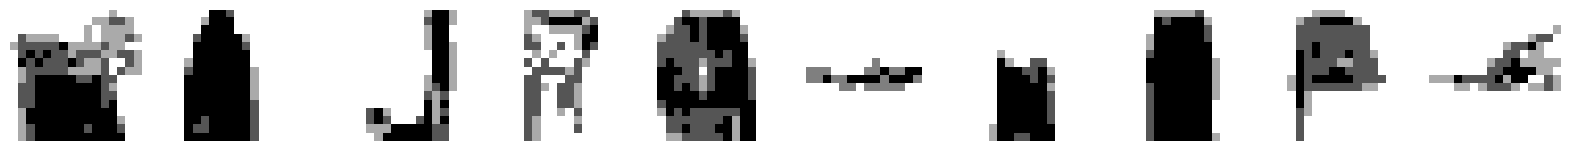

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3356
Epoch 52/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3356
Saved to ./output/generated_img_051.png


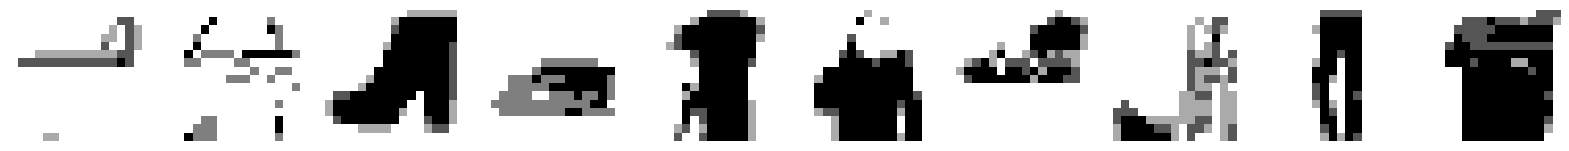

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3356
Epoch 53/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3350
Saved to ./output/generated_img_052.png


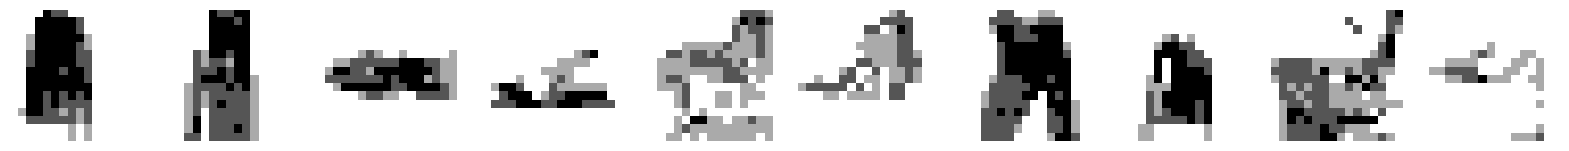

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3350
Epoch 54/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3360
Saved to ./output/generated_img_053.png


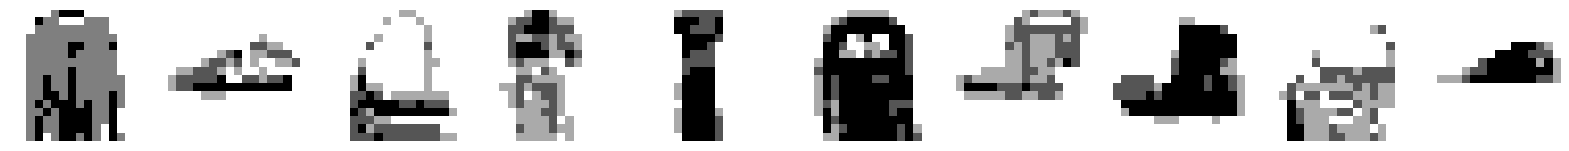

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3360
Epoch 55/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3341
Saved to ./output/generated_img_054.png


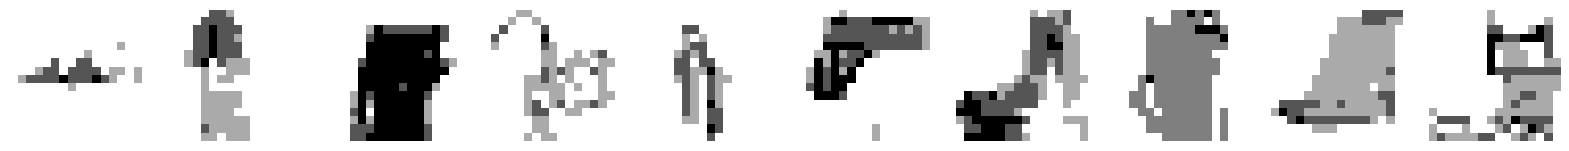

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3341
Epoch 56/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3335
Saved to ./output/generated_img_055.png


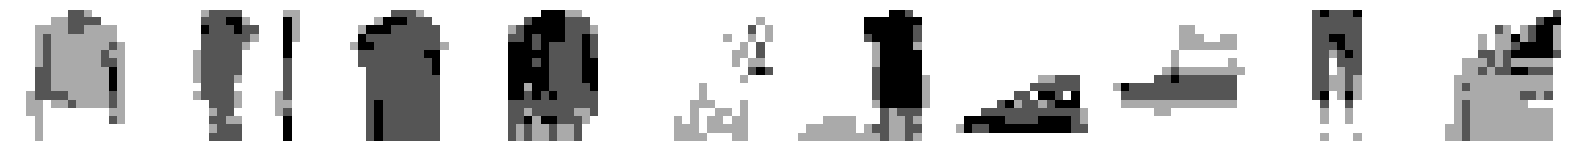

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3335
Epoch 57/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3344
Saved to ./output/generated_img_056.png


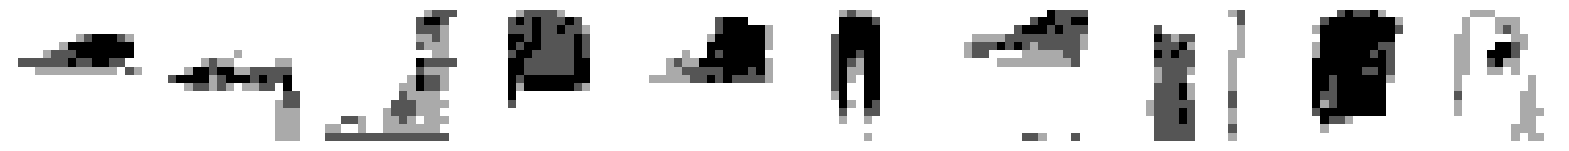

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3344
Epoch 58/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3340
Saved to ./output/generated_img_057.png


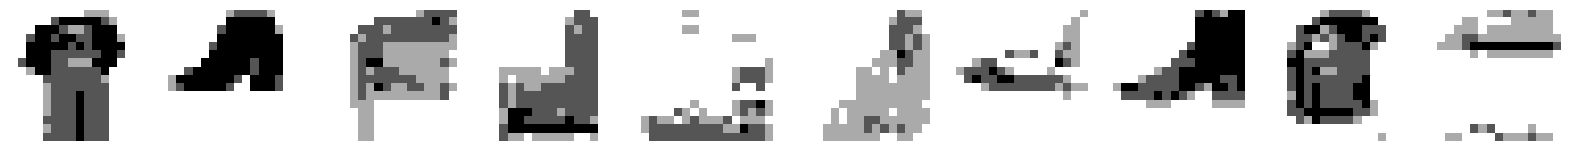

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3340
Epoch 59/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3336
Saved to ./output/generated_img_058.png


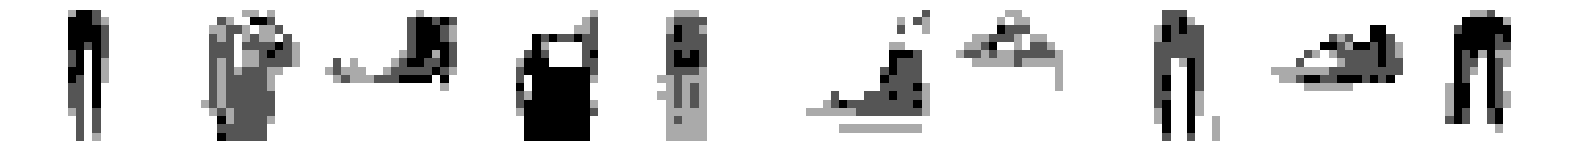

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3336
Epoch 60/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3335
Saved to ./output/generated_img_059.png


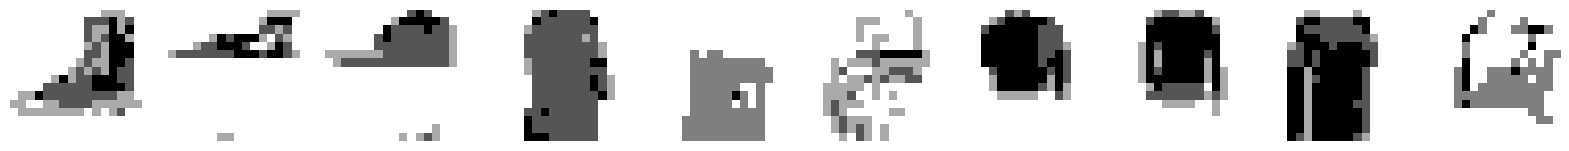

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3335
Epoch 61/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3334
Saved to ./output/generated_img_060.png


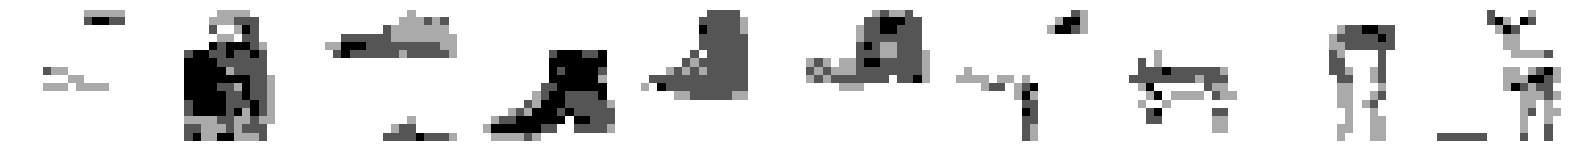

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3334
Epoch 62/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3321
Saved to ./output/generated_img_061.png


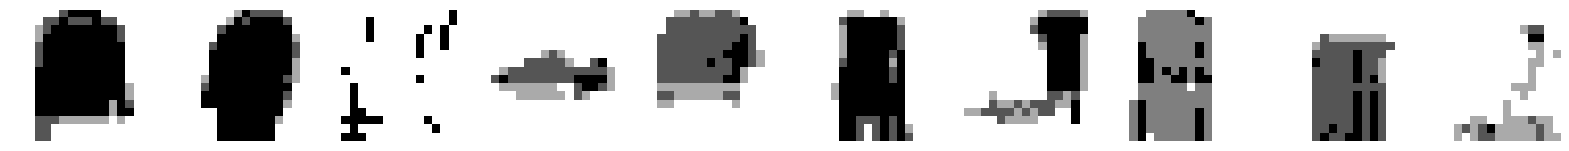

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3321
Epoch 63/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3326
Saved to ./output/generated_img_062.png


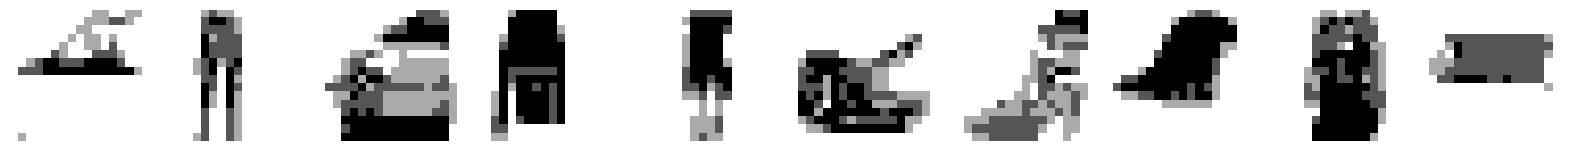

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3326
Epoch 64/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3322
Saved to ./output/generated_img_063.png


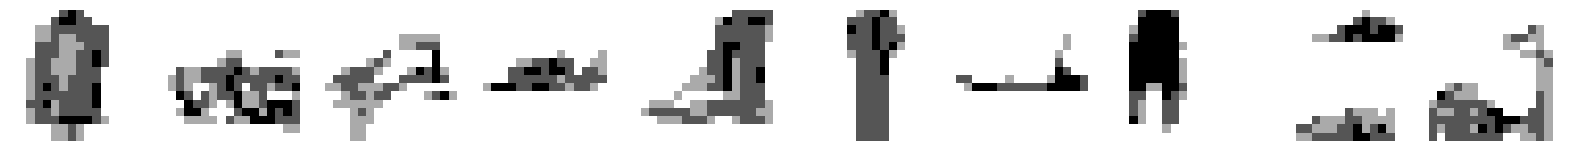

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3322
Epoch 65/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3326
Saved to ./output/generated_img_064.png


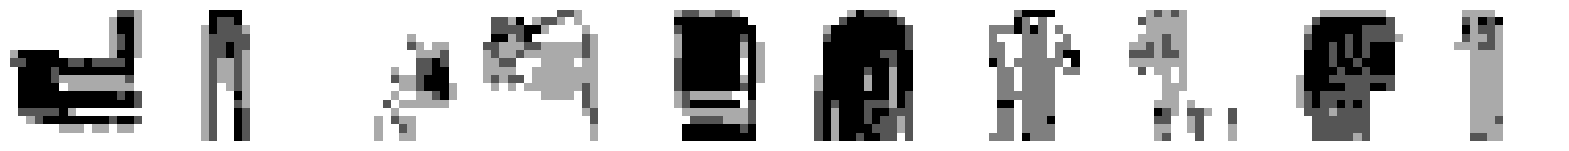

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.3326
Epoch 66/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3321
Saved to ./output/generated_img_065.png


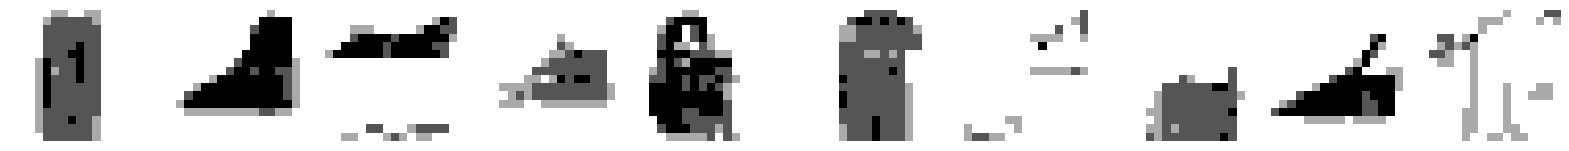

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3321
Epoch 67/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3322
Saved to ./output/generated_img_066.png


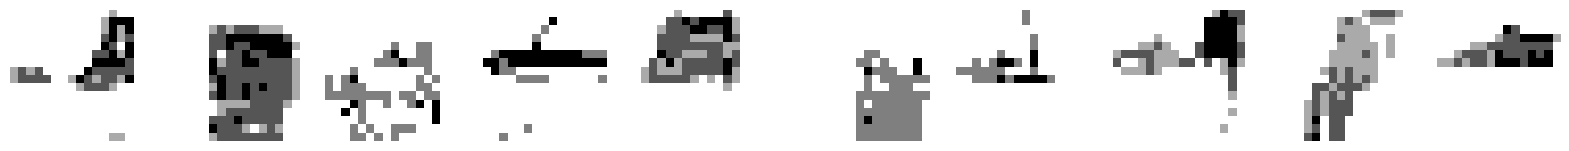

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3322
Epoch 68/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3331
Saved to ./output/generated_img_067.png


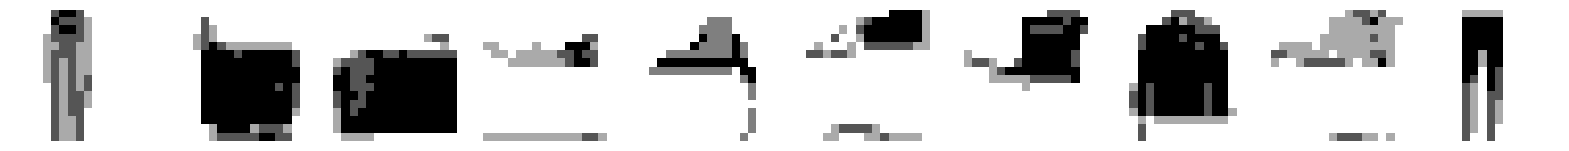

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3330
Epoch 69/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3313
Saved to ./output/generated_img_068.png


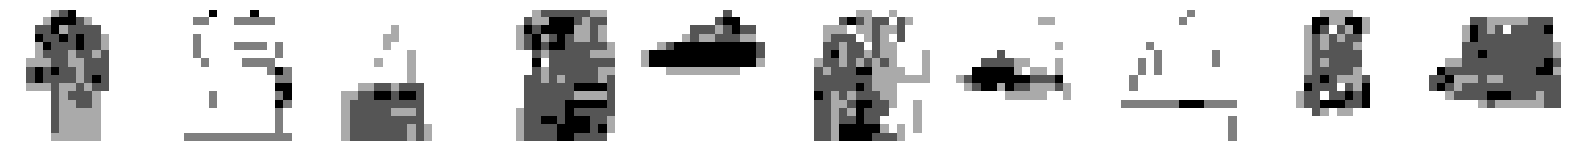

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3313
Epoch 70/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3305
Saved to ./output/generated_img_069.png


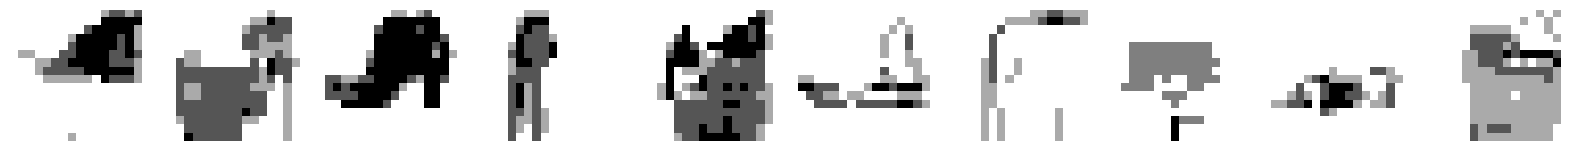

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3305
Epoch 71/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3320
Saved to ./output/generated_img_070.png


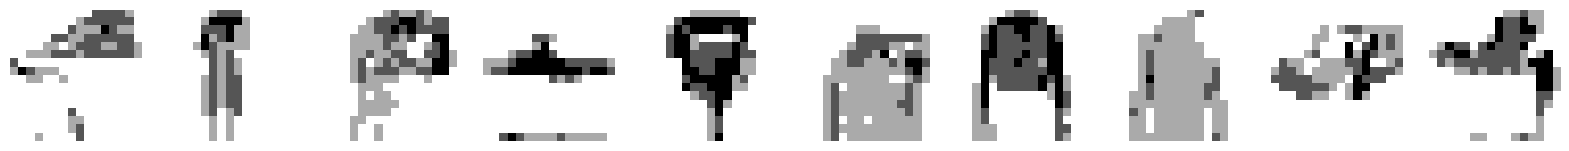

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3320
Epoch 72/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3311
Saved to ./output/generated_img_071.png


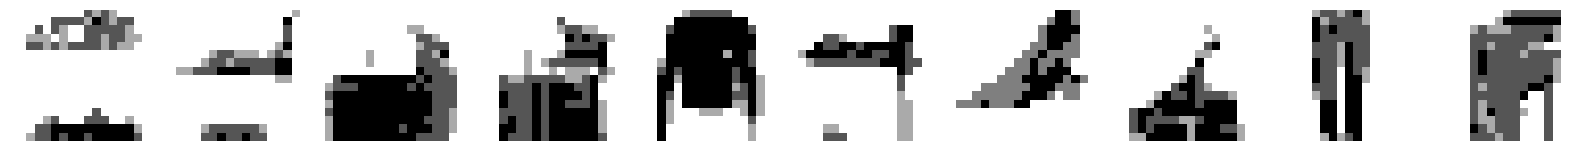

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3311
Epoch 73/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3318
Saved to ./output/generated_img_072.png


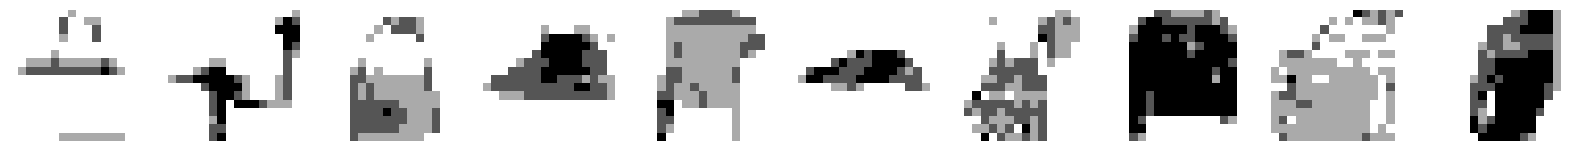

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3318
Epoch 74/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3312
Saved to ./output/generated_img_073.png


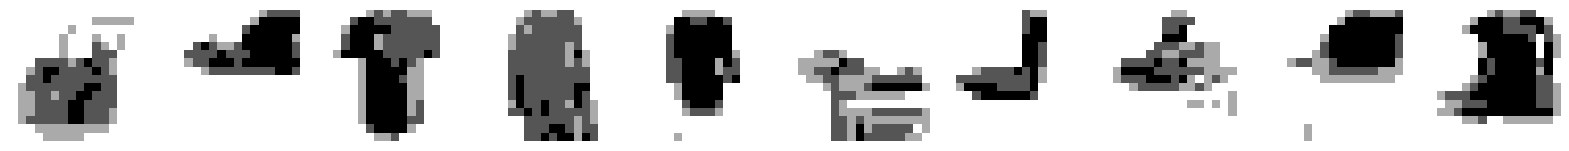

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3312
Epoch 75/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3309
Saved to ./output/generated_img_074.png


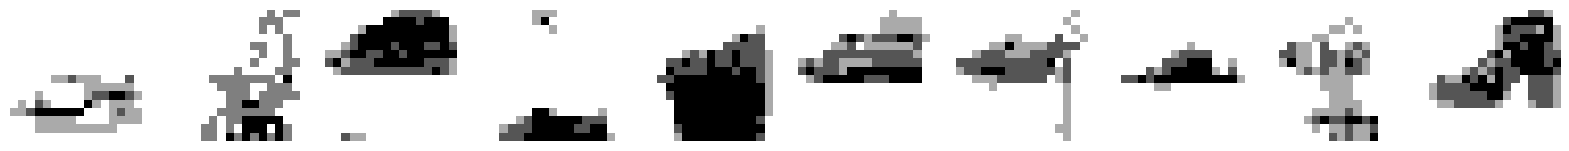

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3309
Epoch 76/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3306
Saved to ./output/generated_img_075.png


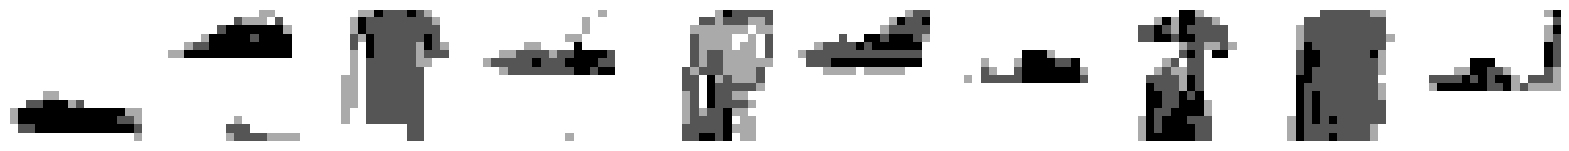

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3306
Epoch 77/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3299
Saved to ./output/generated_img_076.png


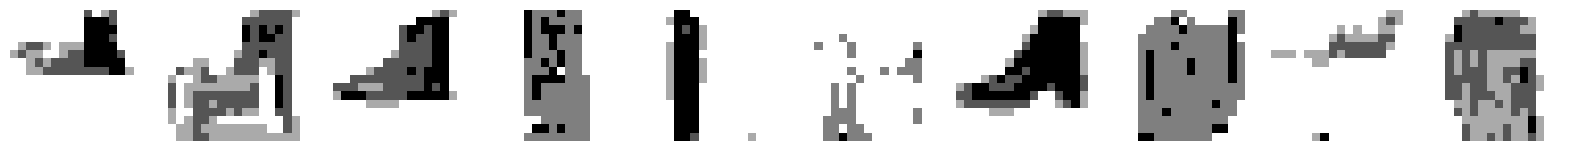

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3299
Epoch 78/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3309
Saved to ./output/generated_img_077.png


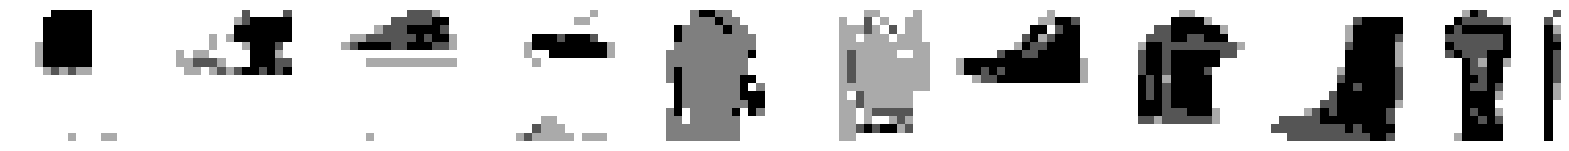

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3309
Epoch 79/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3304
Saved to ./output/generated_img_078.png


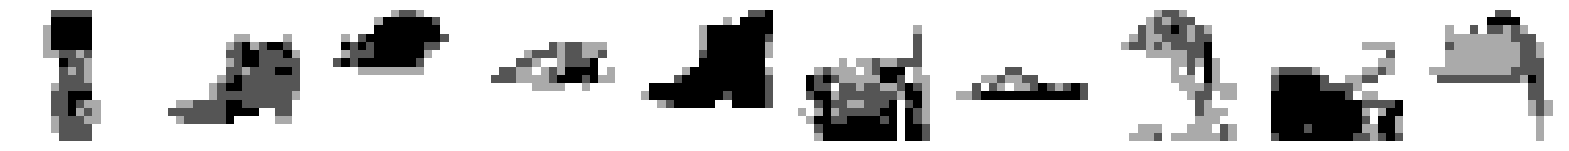

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3304
Epoch 80/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3304
Saved to ./output/generated_img_079.png


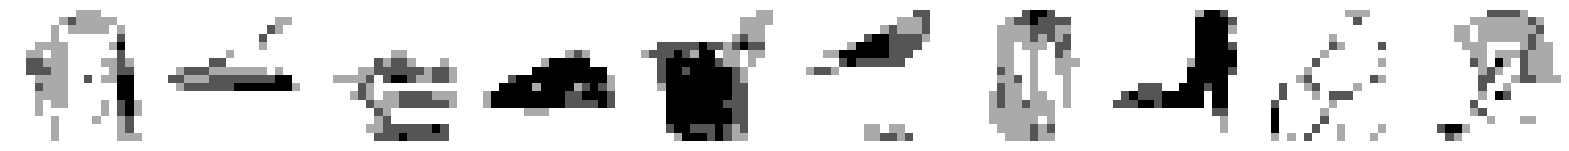

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3304
Epoch 81/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3294
Saved to ./output/generated_img_080.png


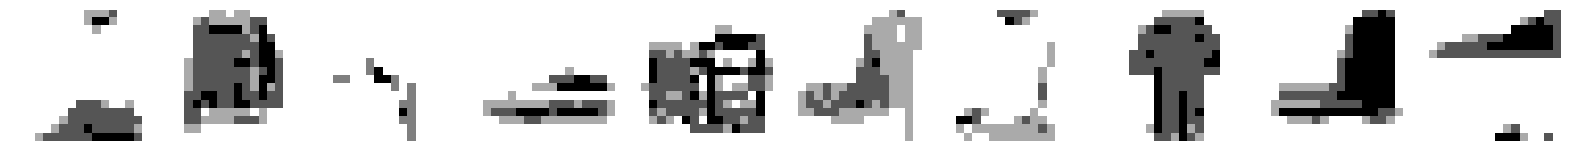

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3294
Epoch 82/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3299
Saved to ./output/generated_img_081.png


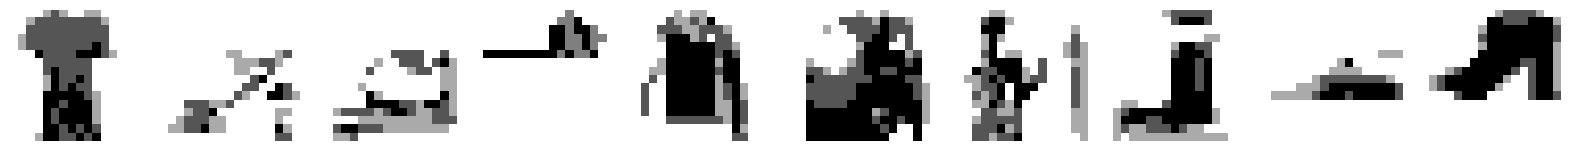

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3299
Epoch 83/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3307
Saved to ./output/generated_img_082.png


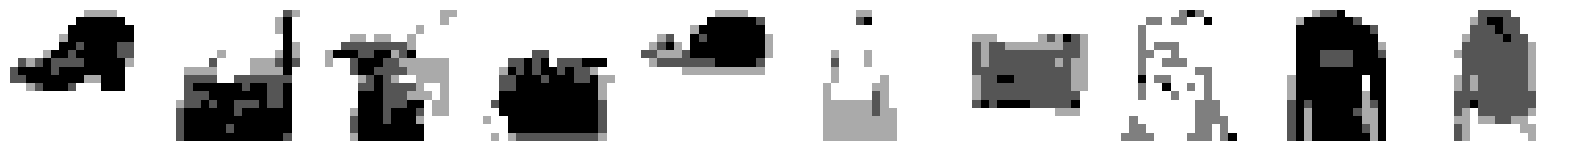

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3307
Epoch 84/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3289
Saved to ./output/generated_img_083.png


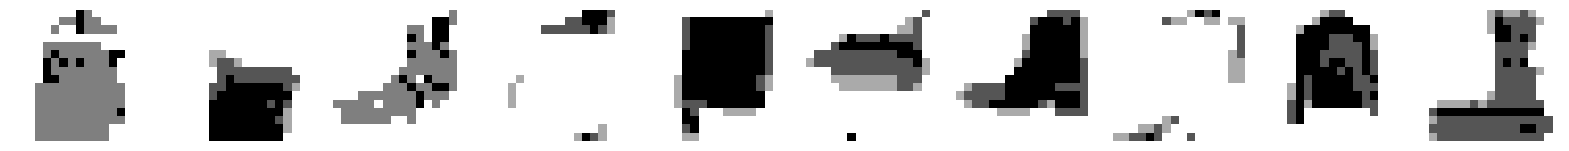

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3289
Epoch 85/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3302
Saved to ./output/generated_img_084.png


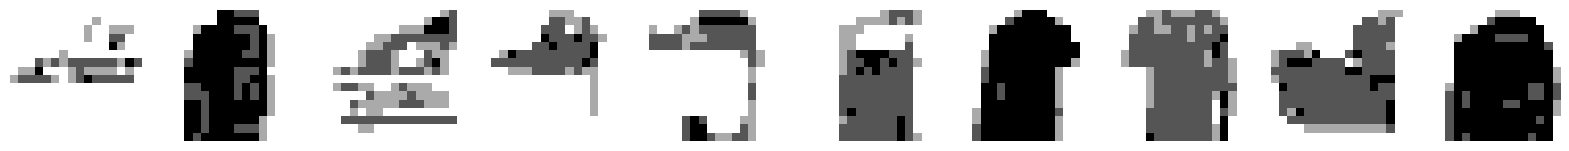

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3302
Epoch 86/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3299
Saved to ./output/generated_img_085.png


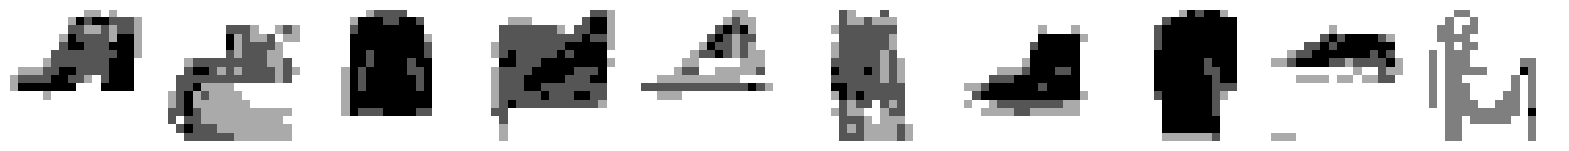

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3299
Epoch 87/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3290
Saved to ./output/generated_img_086.png


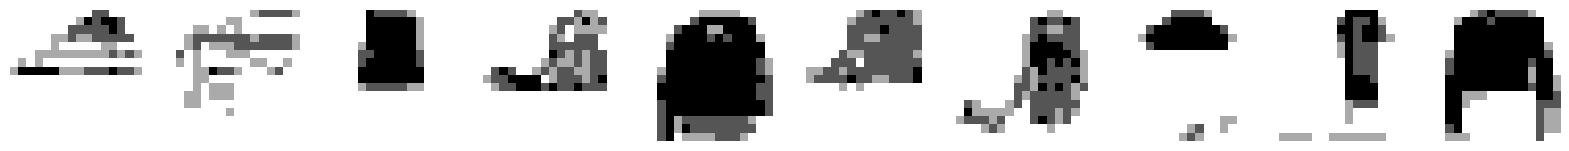

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3290
Epoch 88/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3286
Saved to ./output/generated_img_087.png


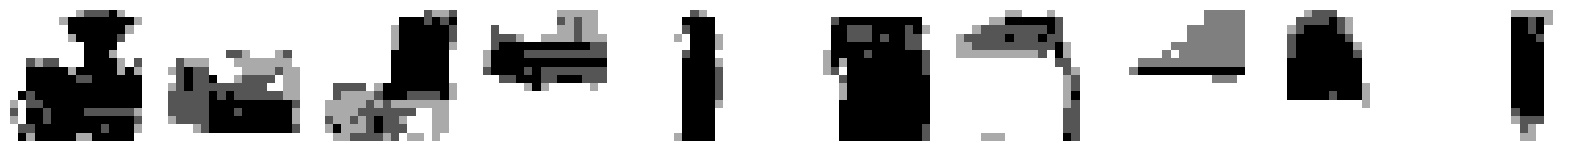

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3286
Epoch 89/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3291
Saved to ./output/generated_img_088.png


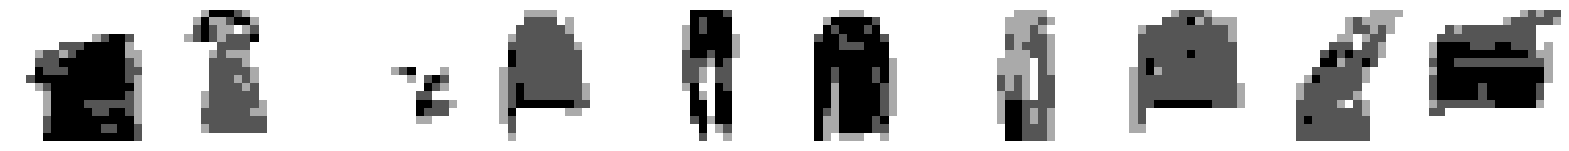

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3291
Epoch 90/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3291
Saved to ./output/generated_img_089.png


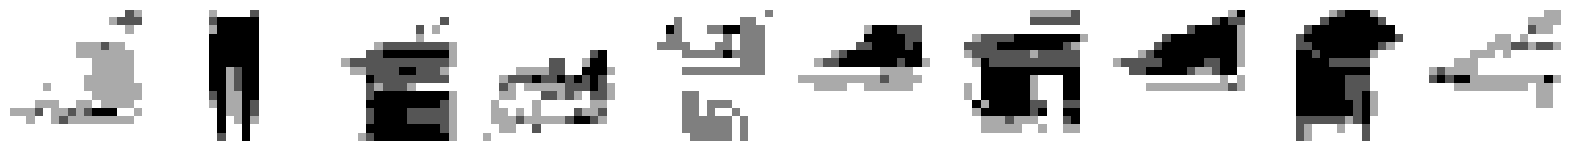

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3291
Epoch 91/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3285
Saved to ./output/generated_img_090.png


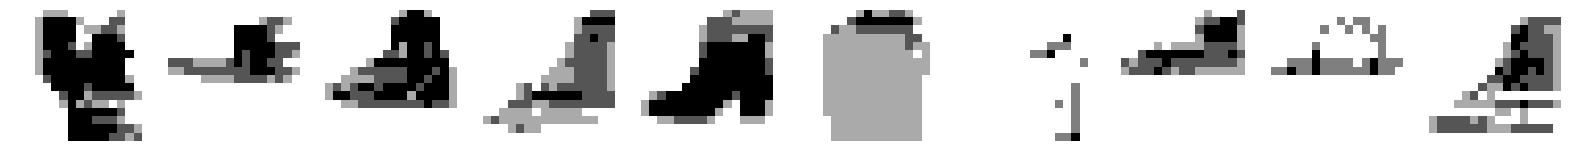

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3285
Epoch 92/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3281
Saved to ./output/generated_img_091.png


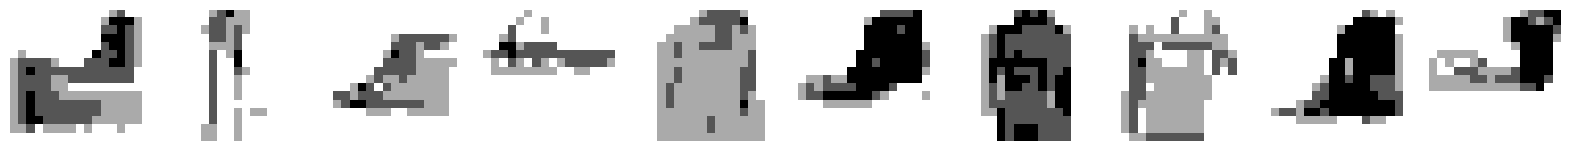

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3281
Epoch 93/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3287
Saved to ./output/generated_img_092.png


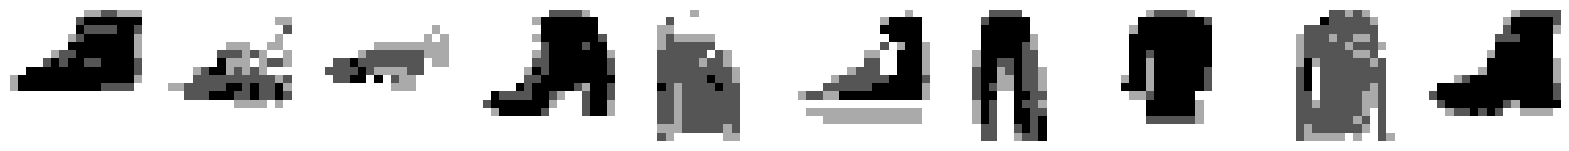

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3287
Epoch 94/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3276
Saved to ./output/generated_img_093.png


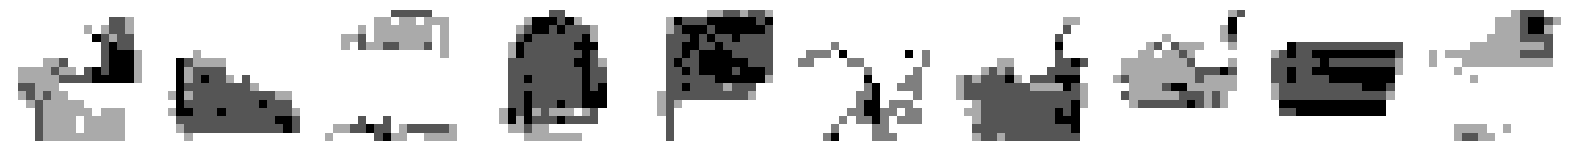

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3276
Epoch 95/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3284
Saved to ./output/generated_img_094.png


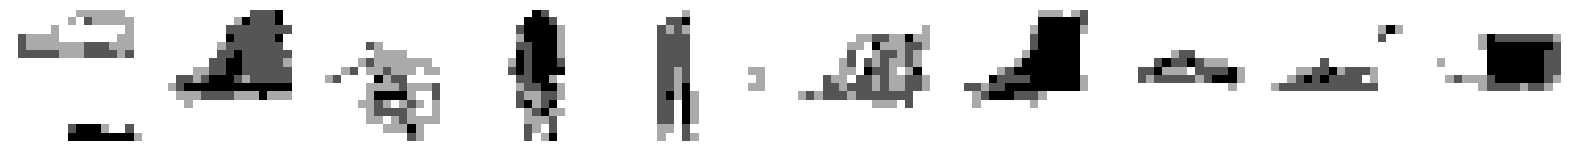

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3284
Epoch 96/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3280
Saved to ./output/generated_img_095.png


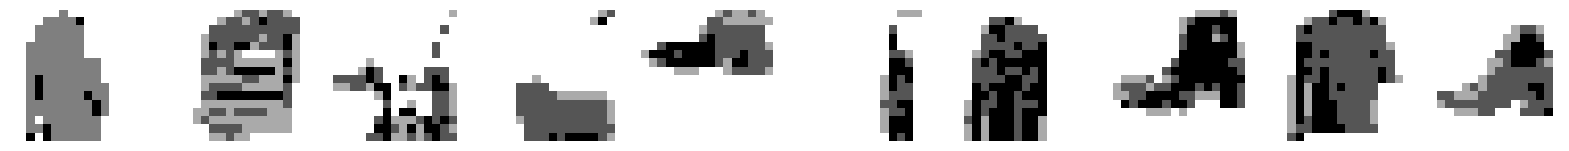

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3280
Epoch 97/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3283
Saved to ./output/generated_img_096.png


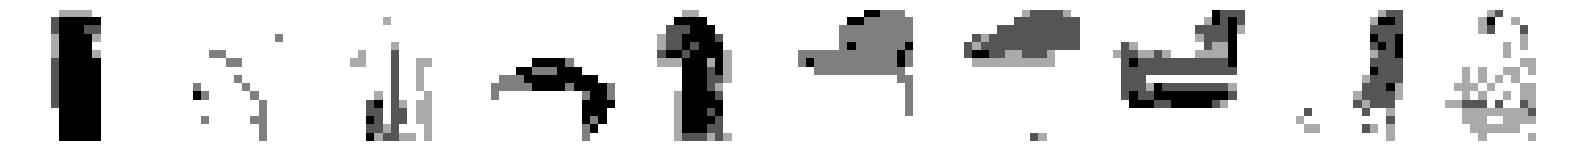

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3283
Epoch 98/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3273
Saved to ./output/generated_img_097.png


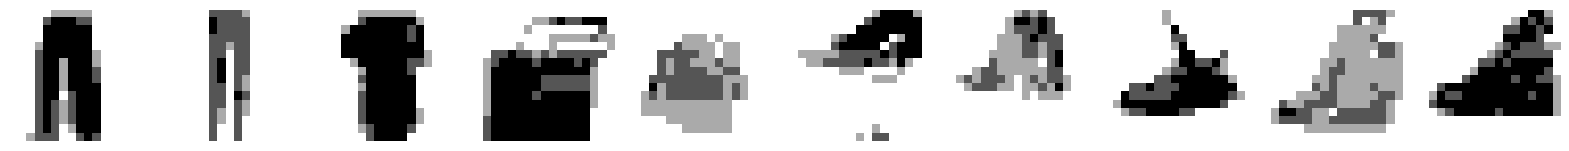

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3273
Epoch 99/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3268
Saved to ./output/generated_img_098.png


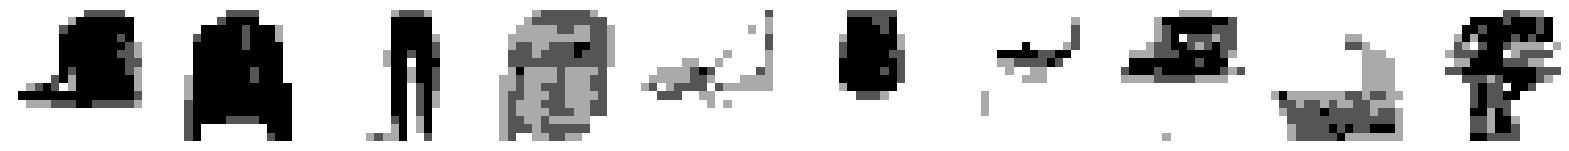

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3268
Epoch 100/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3269
Saved to ./output/generated_img_099.png


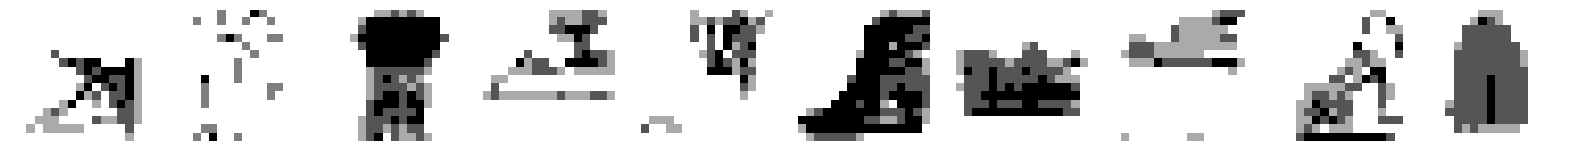

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3269
Epoch 101/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3276
Saved to ./output/generated_img_100.png


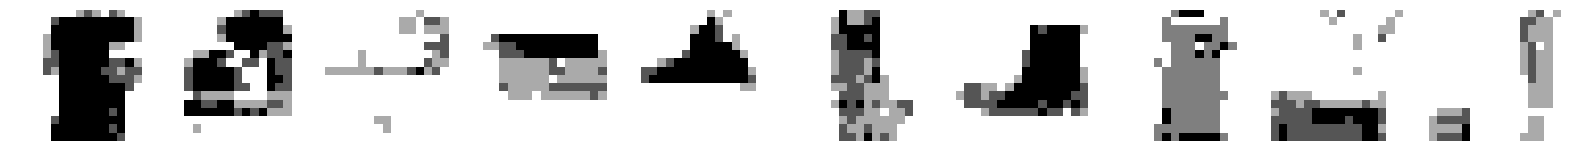

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.3276
Epoch 102/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3273
Saved to ./output/generated_img_101.png


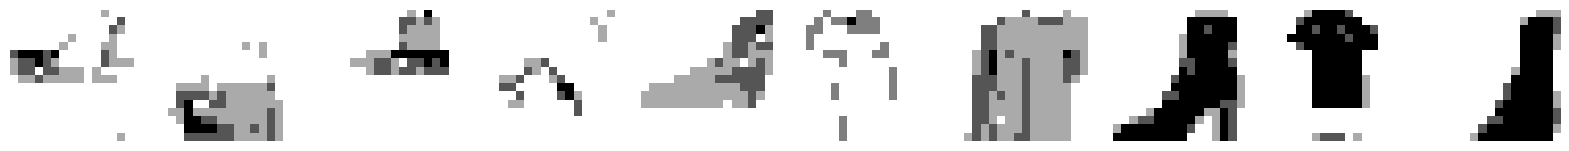

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3273
Epoch 103/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3271
Saved to ./output/generated_img_102.png


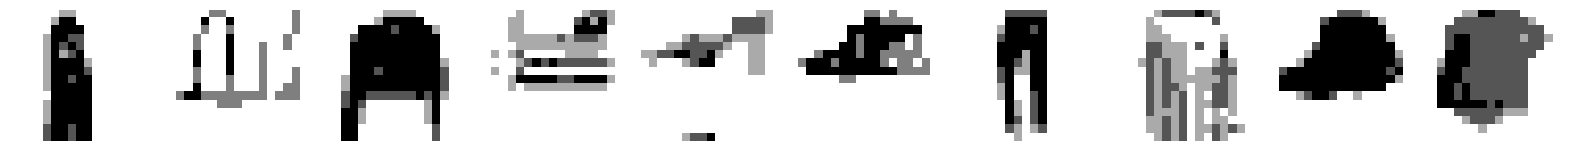

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3271
Epoch 104/150
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3262
Saved to ./output/generated_img_103.png


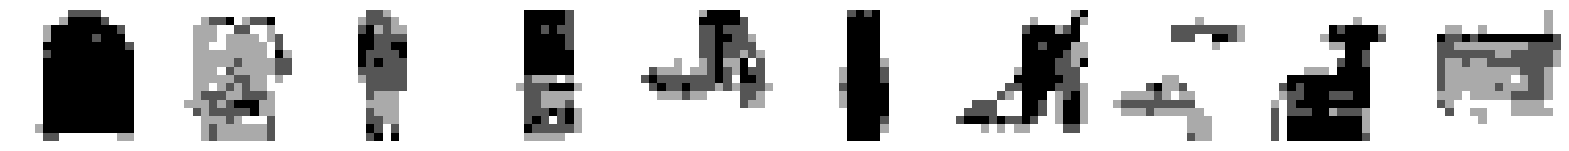

469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 0.3262
Epoch 105/150
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3276
Saved to ./output/generated_img_104.png


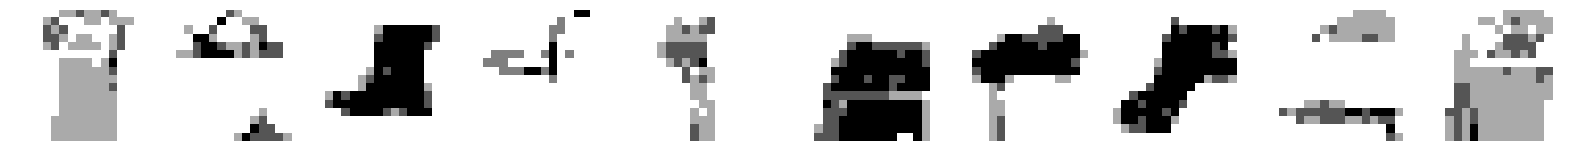

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - loss: 0.3276
Epoch 106/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3266
Saved to ./output/generated_img_105.png


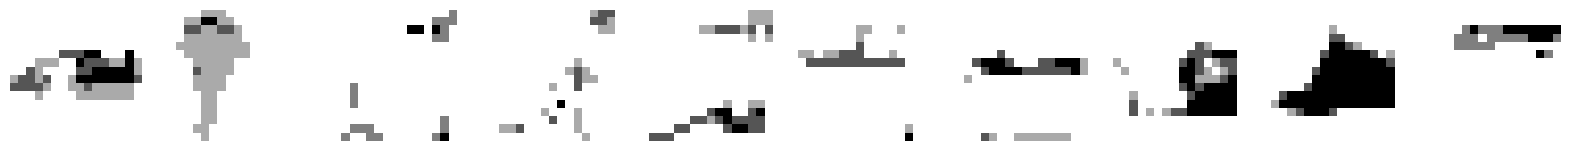

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3266
Epoch 107/150
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3259
Saved to ./output/generated_img_106.png


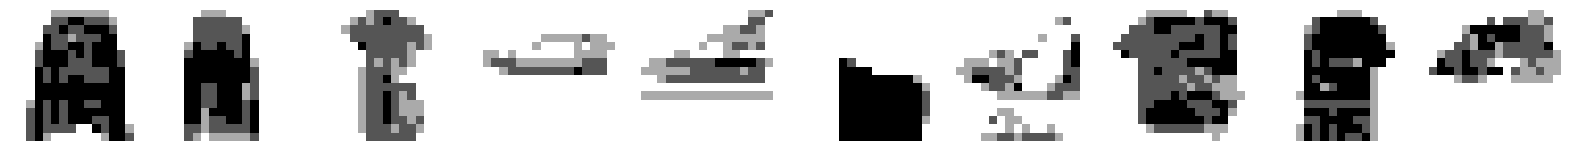

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3259
Epoch 108/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3261
Saved to ./output/generated_img_107.png


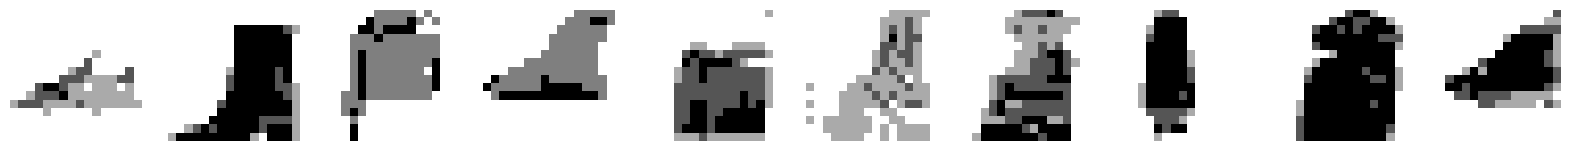

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.3261
Epoch 109/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3271
Saved to ./output/generated_img_108.png


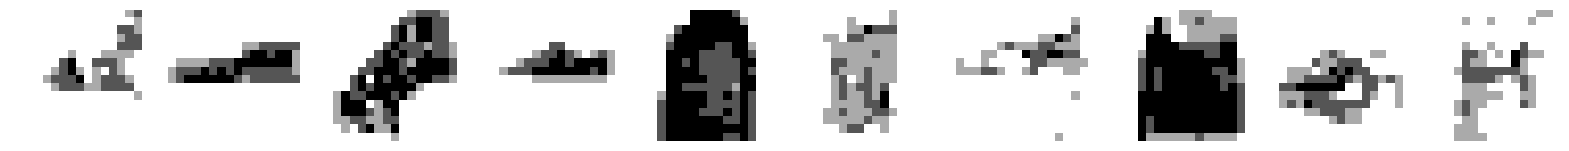

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3271
Epoch 110/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3269
Saved to ./output/generated_img_109.png


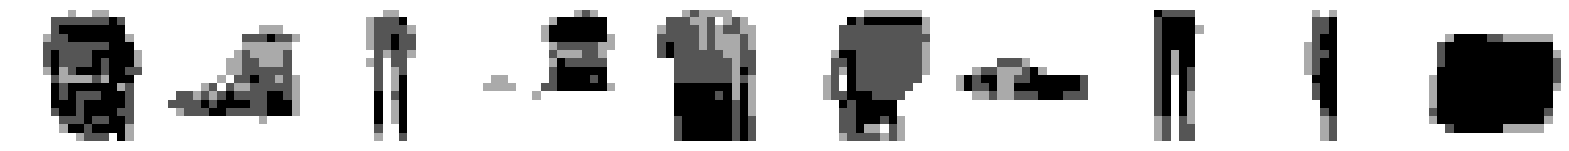

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3269
Epoch 111/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3271
Saved to ./output/generated_img_110.png


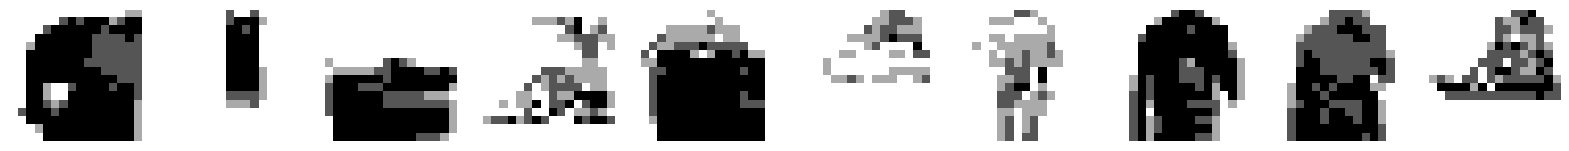

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3271
Epoch 112/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3265
Saved to ./output/generated_img_111.png


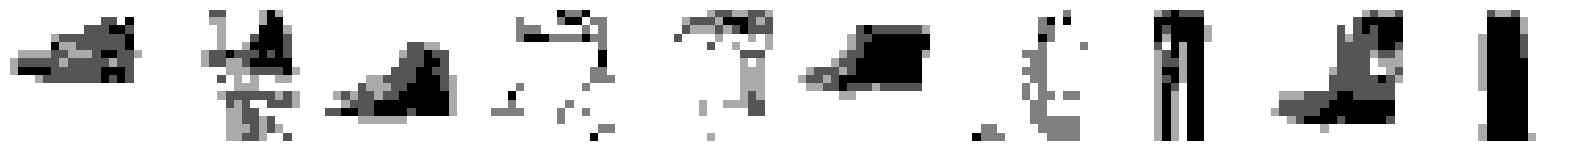

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3265
Epoch 113/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3263
Saved to ./output/generated_img_112.png


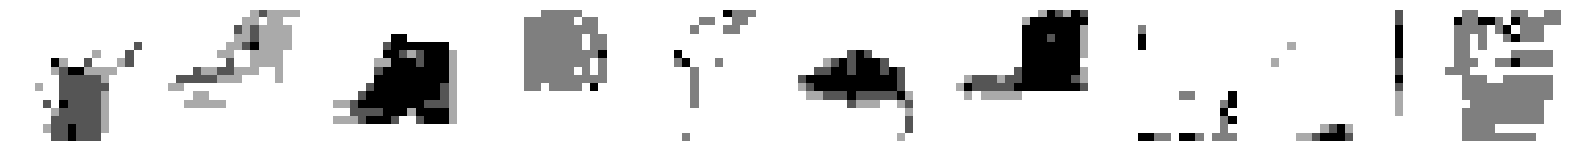

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3263
Epoch 114/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3267
Saved to ./output/generated_img_113.png


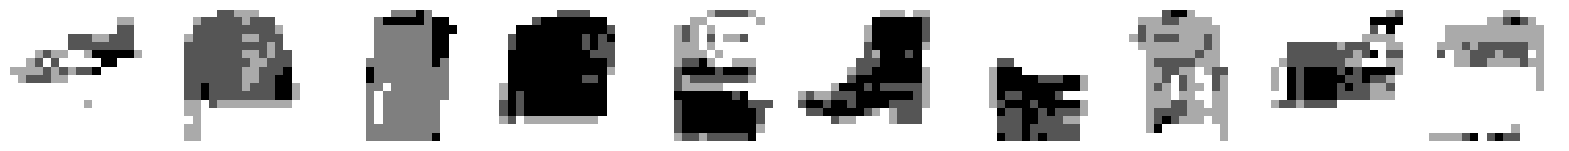

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.3267
Epoch 115/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3266
Saved to ./output/generated_img_114.png


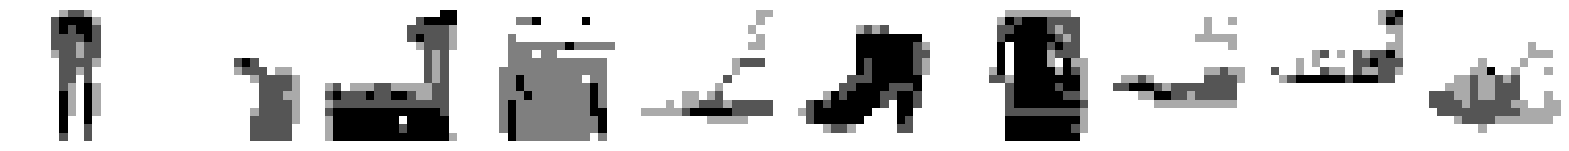

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.3266
Epoch 116/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3256
Saved to ./output/generated_img_115.png


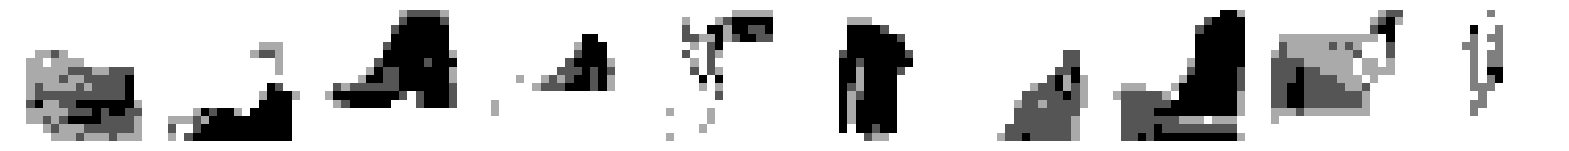

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3256
Epoch 117/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3266
Saved to ./output/generated_img_116.png


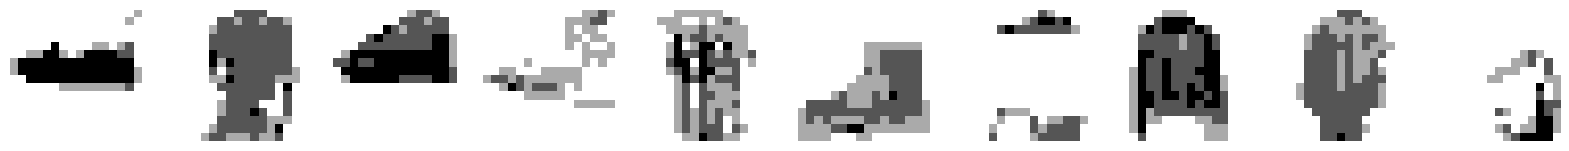

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.3266
Epoch 118/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3261
Saved to ./output/generated_img_117.png


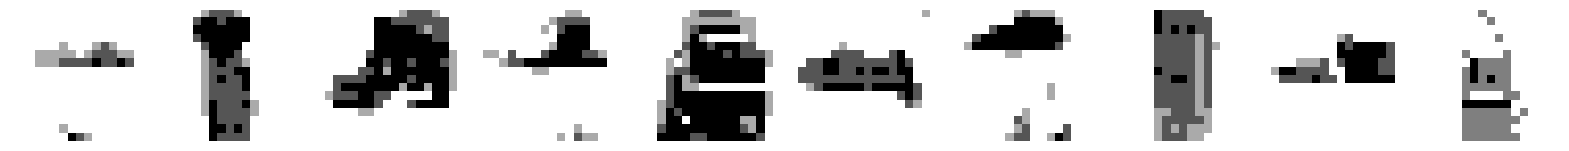

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3261
Epoch 119/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3260
Saved to ./output/generated_img_118.png


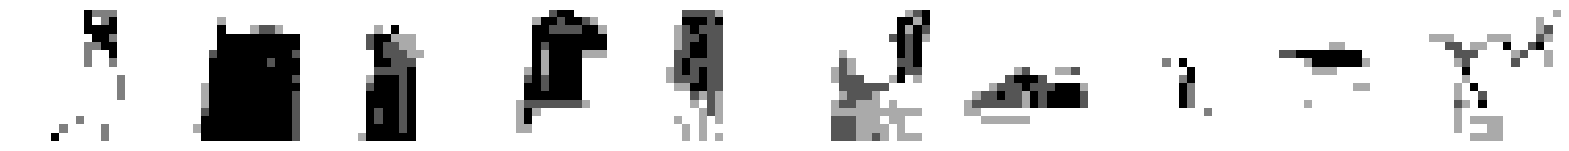

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.3260
Epoch 120/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3256
Saved to ./output/generated_img_119.png


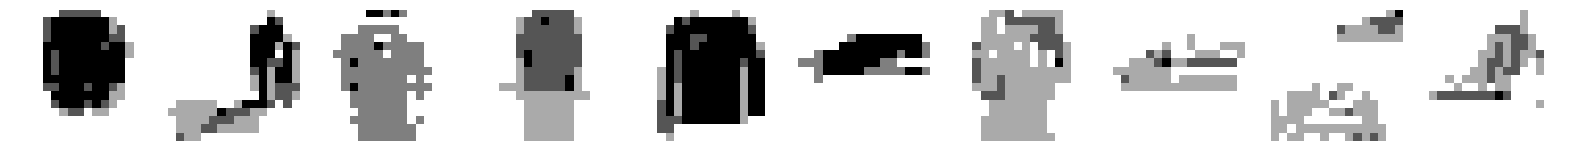

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3256
Epoch 121/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3249
Saved to ./output/generated_img_120.png


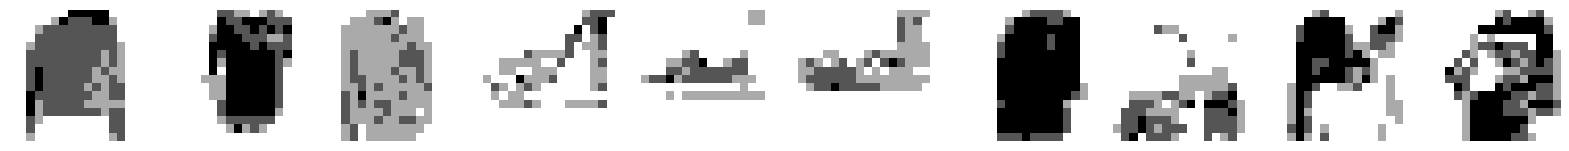

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3249
Epoch 122/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3256
Saved to ./output/generated_img_121.png


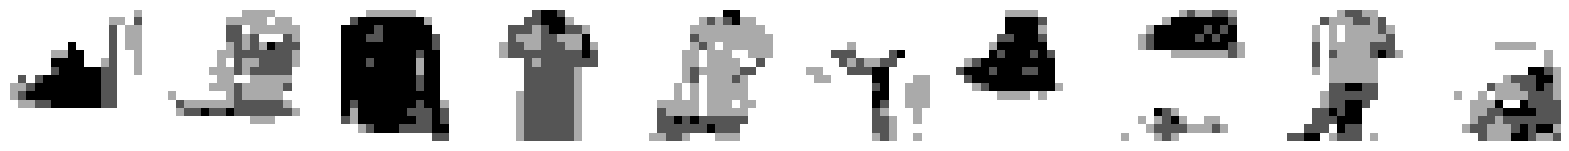

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3256
Epoch 123/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3243
Saved to ./output/generated_img_122.png


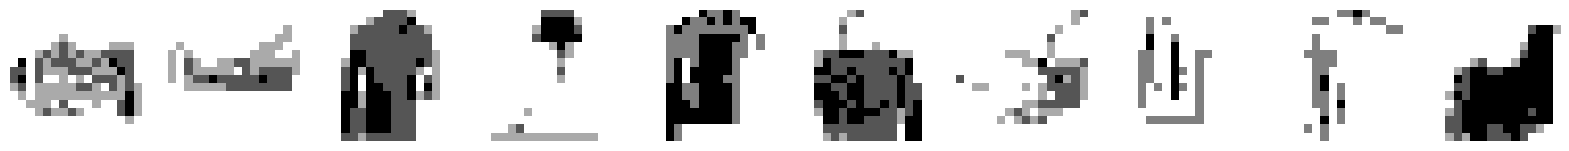

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3243
Epoch 124/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3257
Saved to ./output/generated_img_123.png


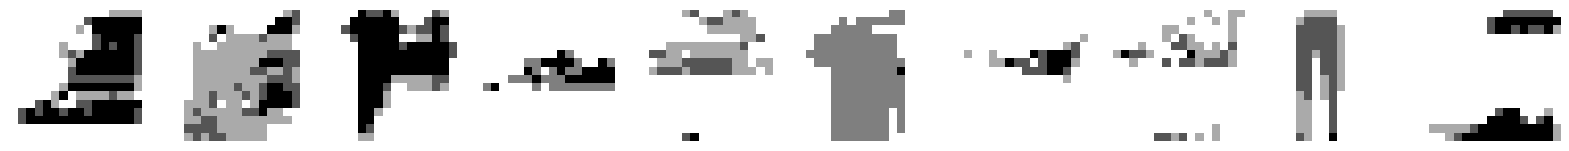

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3257
Epoch 125/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3255
Saved to ./output/generated_img_124.png


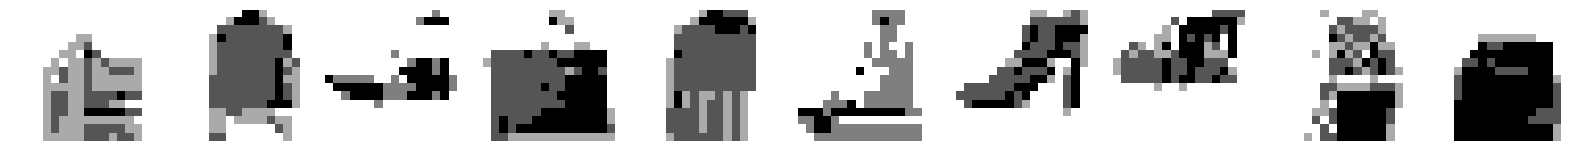

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.3255
Epoch 126/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3248
Saved to ./output/generated_img_125.png


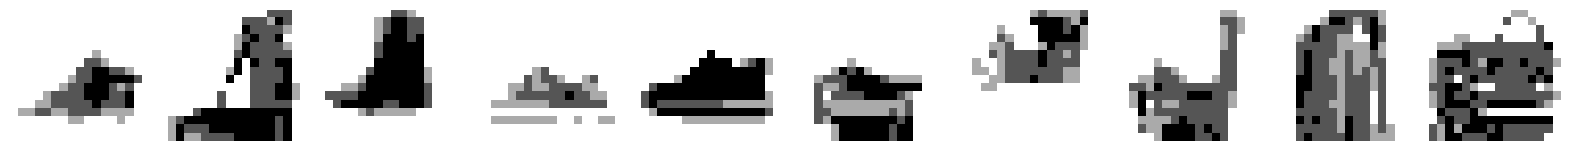

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3248
Epoch 127/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3254
Saved to ./output/generated_img_126.png


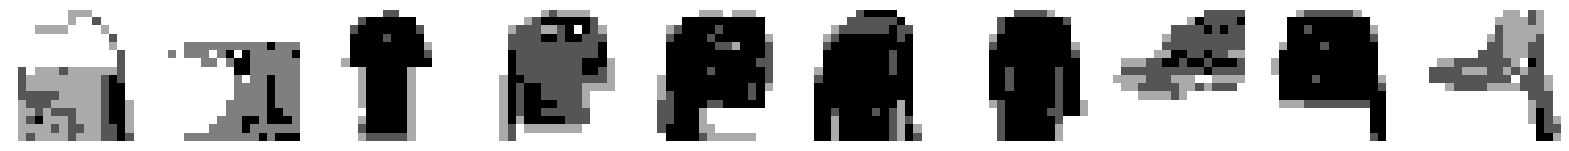

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3254
Epoch 128/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3252
Saved to ./output/generated_img_127.png


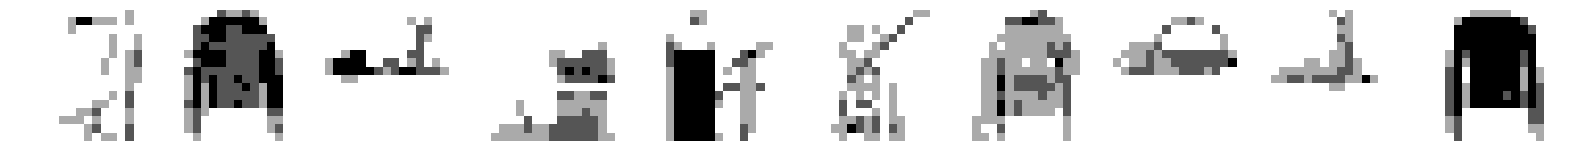

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3252
Epoch 129/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3244
Saved to ./output/generated_img_128.png


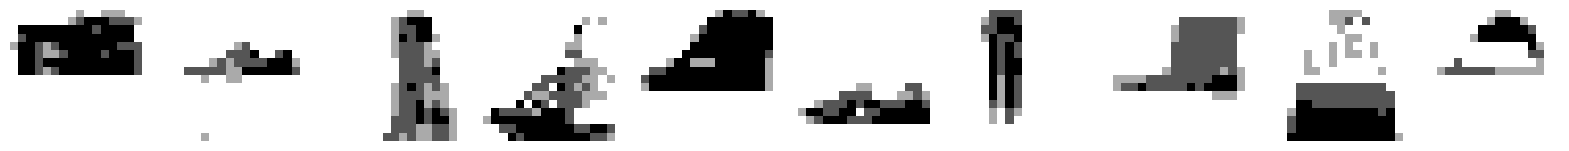

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3245
Epoch 130/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3242
Saved to ./output/generated_img_129.png


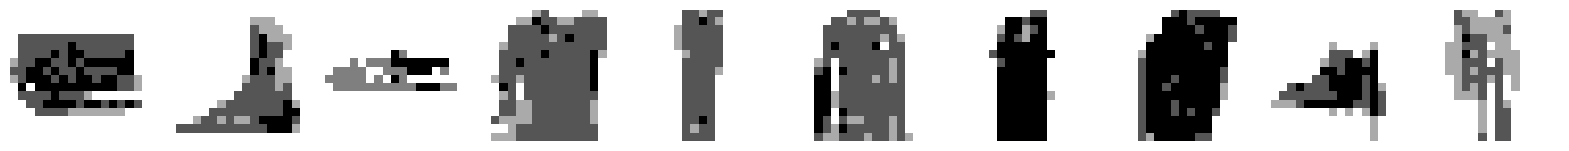

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.3242
Epoch 131/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3244
Saved to ./output/generated_img_130.png


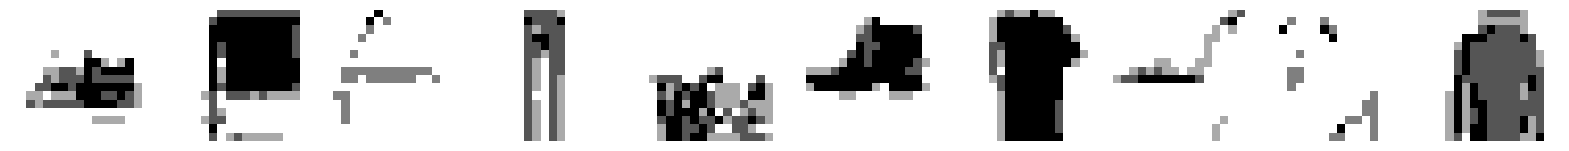

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3244
Epoch 132/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3246
Saved to ./output/generated_img_131.png


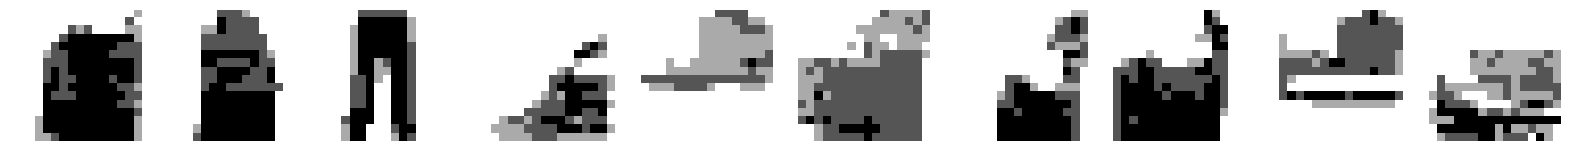

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3246
Epoch 133/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3247
Saved to ./output/generated_img_132.png


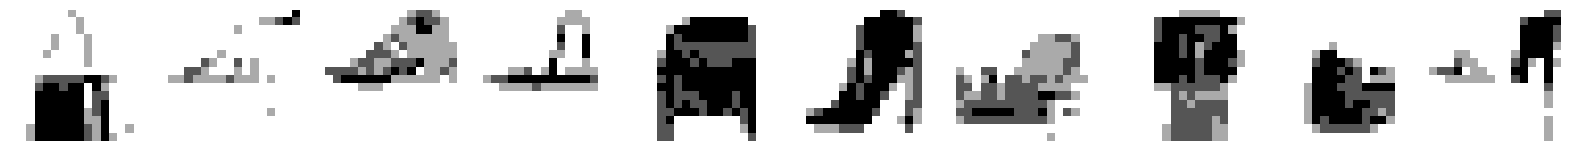

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3247
Epoch 134/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3242
Saved to ./output/generated_img_133.png


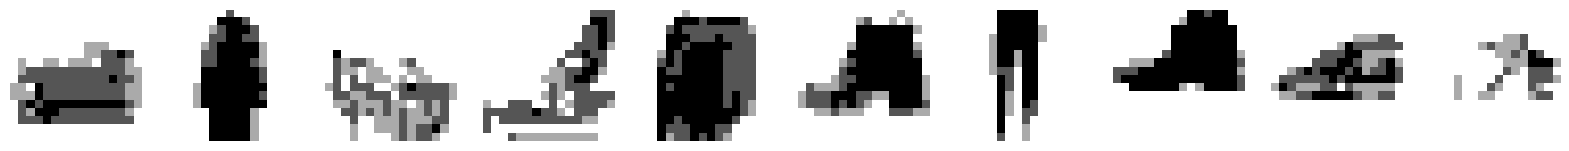

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3242
Epoch 135/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3245
Saved to ./output/generated_img_134.png


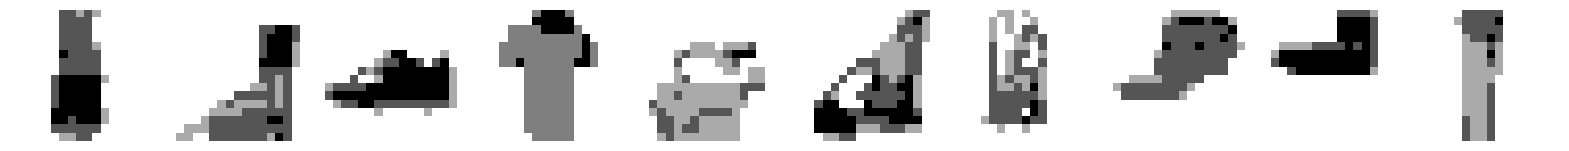

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3245
Epoch 136/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3248
Saved to ./output/generated_img_135.png


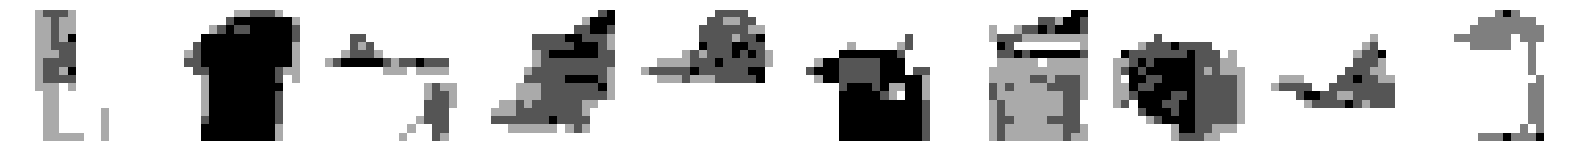

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.3248
Epoch 137/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3242
Saved to ./output/generated_img_136.png


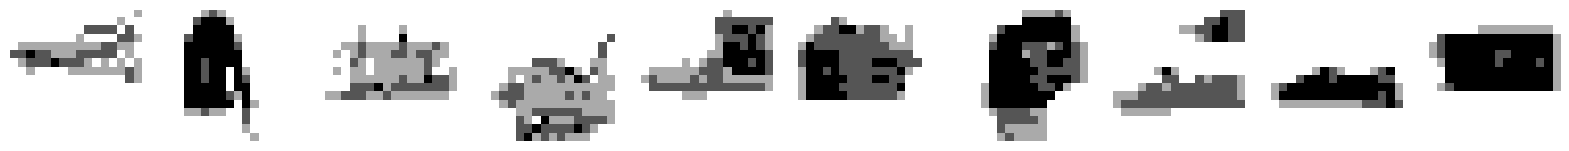

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - loss: 0.3242
Epoch 138/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3242
Saved to ./output/generated_img_137.png


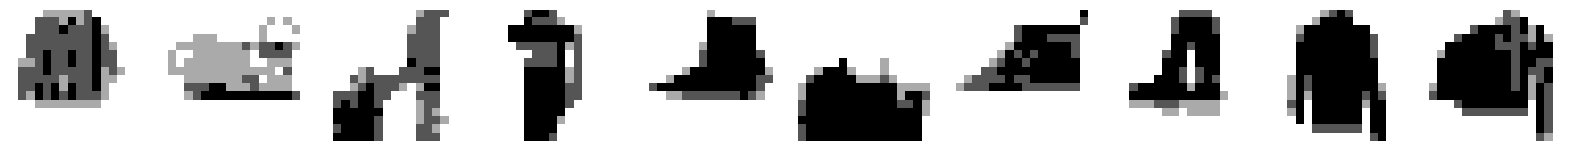

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3242
Epoch 139/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3235
Saved to ./output/generated_img_138.png


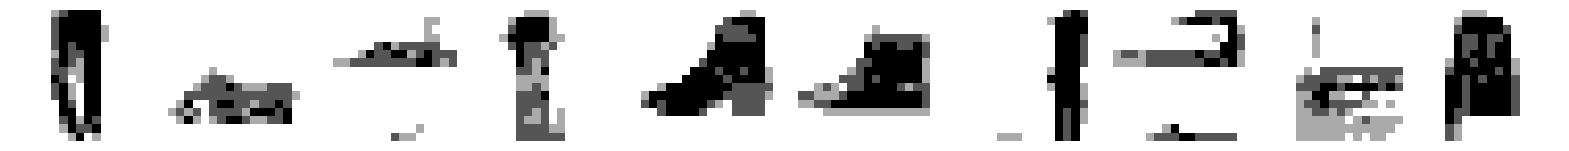

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3235
Epoch 140/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3237
Saved to ./output/generated_img_139.png


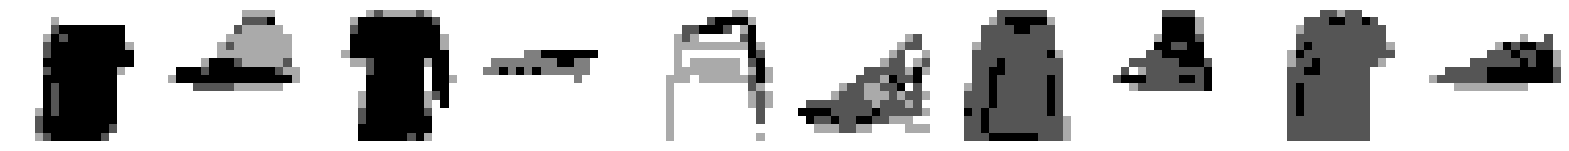

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3237
Epoch 141/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3245
Saved to ./output/generated_img_140.png


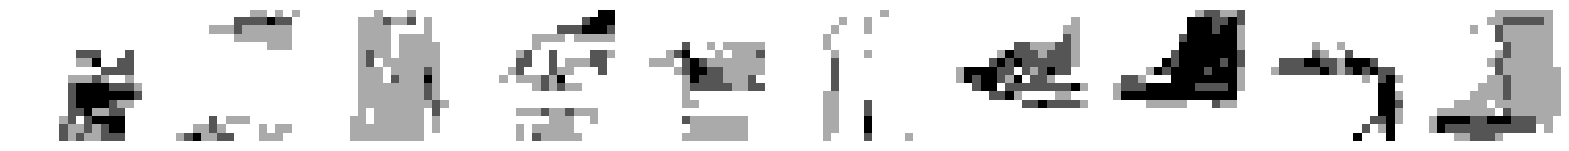

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - loss: 0.3245
Epoch 142/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3233
Saved to ./output/generated_img_141.png


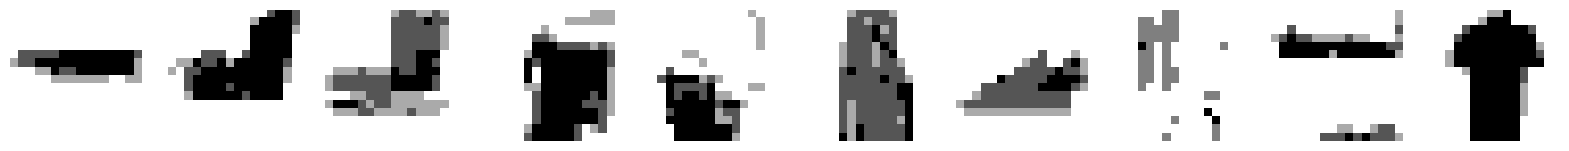

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3233
Epoch 143/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3242
Saved to ./output/generated_img_142.png


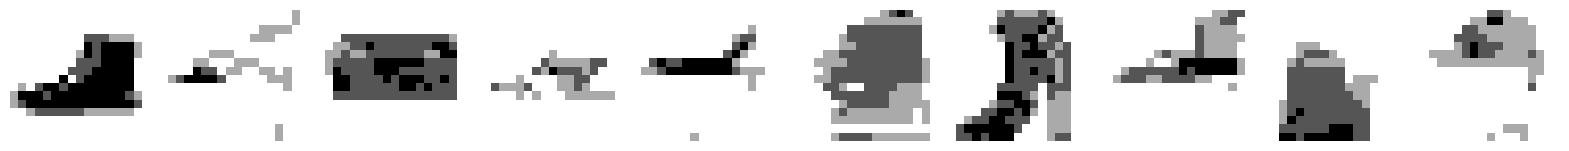

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3242
Epoch 144/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3237
Saved to ./output/generated_img_143.png


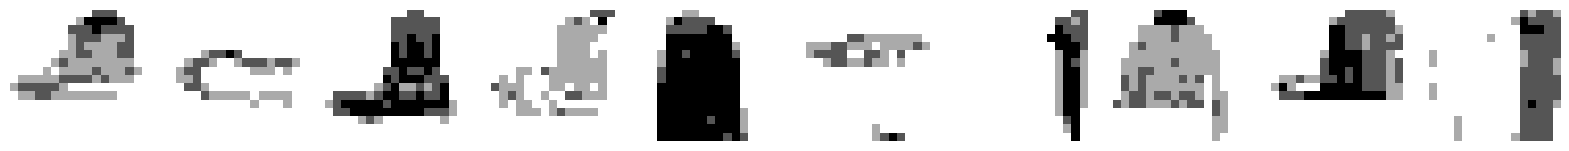

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3238
Epoch 145/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3228
Saved to ./output/generated_img_144.png


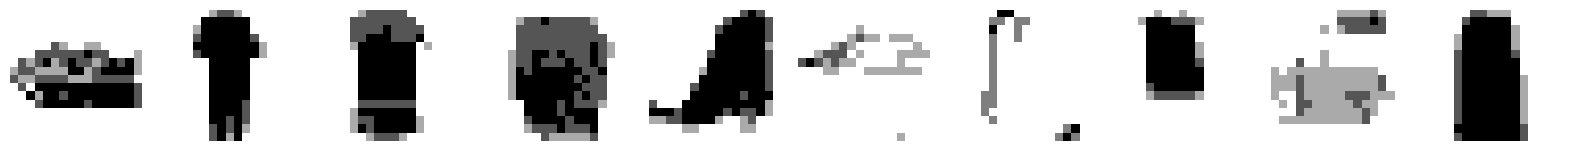

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3228
Epoch 146/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3241
Saved to ./output/generated_img_145.png


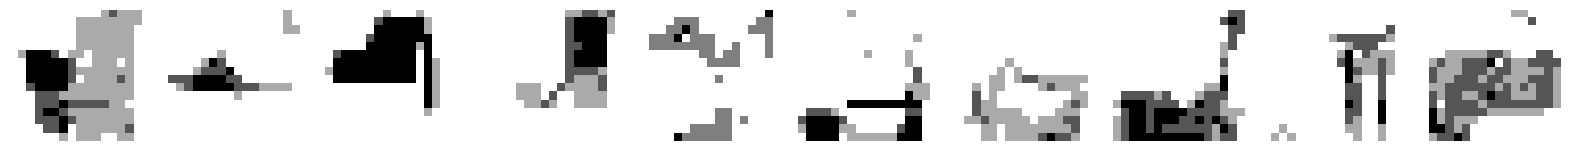

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3241
Epoch 147/150
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3243
Saved to ./output/generated_img_146.png


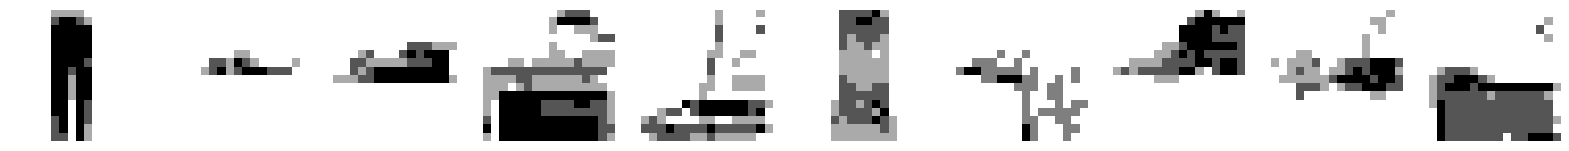

469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - loss: 0.3243
Epoch 148/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3240
Saved to ./output/generated_img_147.png


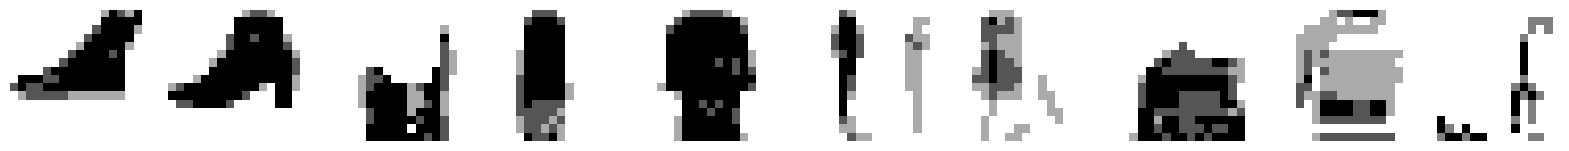

469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 0.3240
Epoch 149/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3238
Saved to ./output/generated_img_148.png


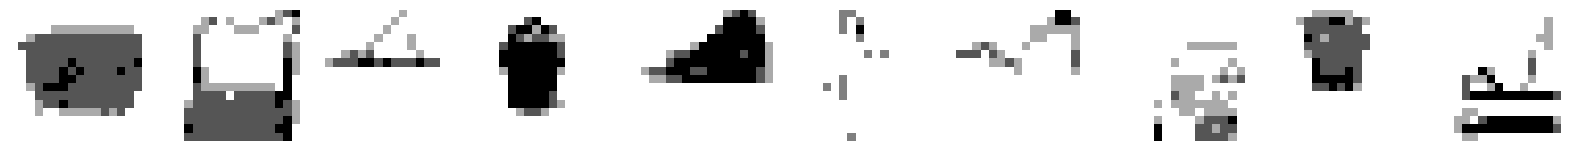

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - loss: 0.3238
Epoch 150/150
466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3232
Saved to ./output/generated_img_149.png


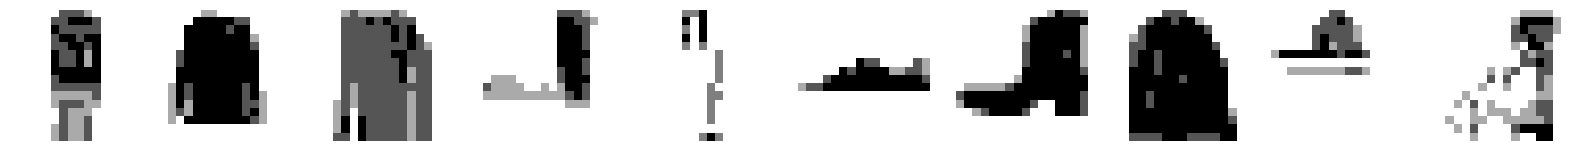

469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 0.3232


In [9]:
BATCH_SIZE = 128
EPOCHS = 150

# Train the PixelCNN model
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

### Generate Images

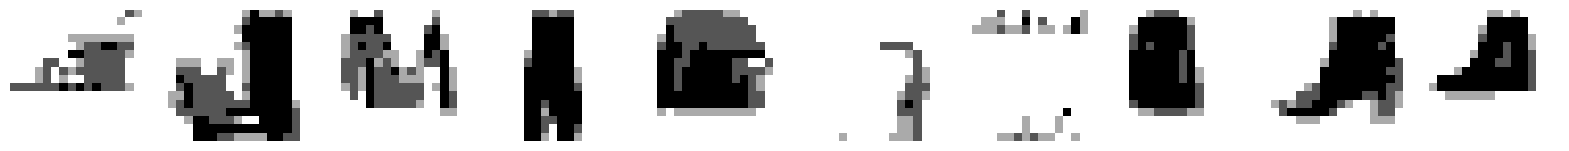

In [10]:
generated_images = img_generator_callback.generate(temperature=1.0)
display(generated_images)